# **I. Install and Import Libraries**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install shap
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 9.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import re
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn import under_sampling, over_sampling

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import shap

import warnings
warnings.filterwarnings("ignore")

# **II. Description of the Data**

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

Source: [Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

**Features Information:**

- id: unique identifier
- gender: "Male", "Female" or "Other"
- age: age of the patient
- hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- ever_married: "No" or "Yes"
- work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- Residence_type: "Rural" or "Urban"
- avg_glucose_level: average glucose level in blood
- bmi: body mass index
- smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"
- stroke: 1 if the patient had a stroke or 0 if not

**Note*: "Unknown" in smoking_status means that the information is unavailable for this patient

# **III. Import the Dataset and Preview**

In [4]:
raw_df = pd.read_csv("/content/drive/MyDrive/Portofolio Data Science/Stroke Prediction/healthcare-dataset-stroke-data.csv")
raw_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# **IV. Data Checking**

## **a. Check Total Rows, Data Types, Missing Values, and Sample Values**

In [5]:
def checking_data(df):
  dtypes = []
  rows = []
  missing_values = []
  unique_values = []
  values = []

  for i in df.columns:
    dtypes.append(df[i].dtype)
    rows.append(df[i].count())
    missing_values.append((df[i].isna().sum()*100)/len(df))
    unique_values.append(df[i].nunique())
    values.append(df[i].unique())

  check = pd.DataFrame({
      "Features": df.columns,
      "Count Rows": rows,
      "Data Types": dtypes,
      "Missing Values (%)": missing_values,
      "Unique Values": unique_values,
      "Sample Values": values,
  })
  
  return check

checking_data(raw_df)

,Features,Count Rows,Data Types,Missing Values (%),Unique Values,Sample Values
0,id,5110,int64,0.000000,5110,"[9046, 51676, 31112, 60182, 1665, 56669, 53882..."
1,gender,5110,object,0.000000,3,"[Male, Female, Other]"
2,age,5110,float64,0.000000,104,"[67.0, 61.0, 80.0, 49.0, 79.0, 81.0, 74.0, 69...."
3,hypertension,5110,int64,0.000000,2,"[0, 1]"
4,heart_disease,5110,int64,0.000000,2,"[1, 0]"
5,ever_married,5110,object,0.000000,2,"[Yes, No]"
6,work_type,5110,object,0.000000,5,"[Private, Self-employed, Govt_job, children, N..."
7,Residence_type,5110,object,0.000000,2,"[Urban, Rural]"
8,avg_glucose_level,5110,float64,0.000000,3979,"[228.69, 202.21, 105.92, 171.23, 174.12, 186.2..."
9,bmi,4909,float64,3.933464,418,"[36.6, nan, 32.5, 34.4, 24.0, 29.0, 27.4, 22.8..."


## **b. Check Data Duplicate**

In [6]:
raw_df.duplicated().any()

False

## **c. Check Imbalance Data**

In [7]:
stroke_yes = raw_df[raw_df["stroke"] == 1]["stroke"].count()
stroke_all = raw_df["stroke"].count()

print(
    f"About {int(stroke_yes/stroke_yes)} in {int(round(stroke_all/stroke_yes, 0))} "
    f"people have a stroke or have a proportion of {round(stroke_yes/stroke_all*100, 2)}%."
)

About 1 in 21 people have a stroke or have a proportion of 4.87%.


**Observations:**

- There is no duplicated data, it can be said that each `id` represents one person/patient's information.
- Apart from the `id` feature, there are 11 features.
- Numeric Features: `age`, `avg_glucose_level`, and `bmi`.
- Categorical Features: `gender`, `hypertension`, `heart_disease`, `ever_married`, `work_type`, `Residence_type`, and `smoking_status`.
- Target: `stroke`.
- There is a missing value in the `bmi` feature of 3.93%.
- The `gender`, `work_type` and `smoking_status` features have several values.
- The data has an unbalanced comparison of strokes and non-strokes. Only about 4.87% of people/patients have stroke in the data.

# **V. Data Cleaning**

In [8]:
df_clean = raw_df.copy()

## **a. Fill in the Missing Values**

Previously, there was a missing value in the `bmi` feature. Before dealing with such values, first look at the statistics of the `bmi` feature to consider a value to include in place of the missing value.

In [9]:
df_clean["bmi"].describe()

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

From the statistical values ​​above, the mean and median values ​​are almost the same. Therefore, the missing values ​​will be filled in with the median value. The median value is more robust against outliers.

In [10]:
df_clean["bmi"] = df_clean["bmi"].fillna(df_clean["bmi"].median())
print('Missing values: ', sum(df_clean.isnull().sum()))

Missing values:  0


## **b. Adjusts Values ​​on Categorical Features**

First, we will look at the frequency of values ​​for the `gender`, `work_type` and `smoking_status` features. This is done as a consideration to adjust its values.

In [11]:
for c in ["gender", "work_type", "smoking_status"]:
  print(f'Count Value {c}:')
  print(df_clean[c].value_counts())
  print("=" * 35)

Count Value gender:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
Count Value work_type:
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Count Value smoking_status:
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


From checking the value above, there are several things that will be done,

- `gender` feature: The other value will be changed to Female, because the Female value has the highest frequency.
- `work_type` feature: Will change the value to only [1, 0]. A value of 1 is for someone who is working and a value of 0 for someone who is not working.
- `smoking_status` feature: These values ​​will not be changed, because unknown values ​​have a fairly high frequency and it is difficult to categorize whether the values ​​are appropriate. Then, the formerly value will remain like this because a person's condition will be very different from those who have never smoked at all.

- Gender

In [12]:
df_clean["gender"] = df_clean["gender"].replace("Other", "Female")
print(df_clean["gender"].value_counts())

Female    2995
Male      2115
Name: gender, dtype: int64


- Work Type

In [13]:
df_clean["work_type"] = df_clean["work_type"].replace({
    "Private": "yes", "Self-employed": "yes", "children": "no", "Govt_job": "yes", "Never_worked": "no"
    })
df_clean = df_clean.rename({"work_type": "working_status"}, axis=1)
print(df_clean["working_status"].value_counts())

yes    4401
no      709
Name: working_status, dtype: int64


# **VI. Exploratory Data Analysis**

In [14]:
df = df_clean.copy()

## **a. Stroke**

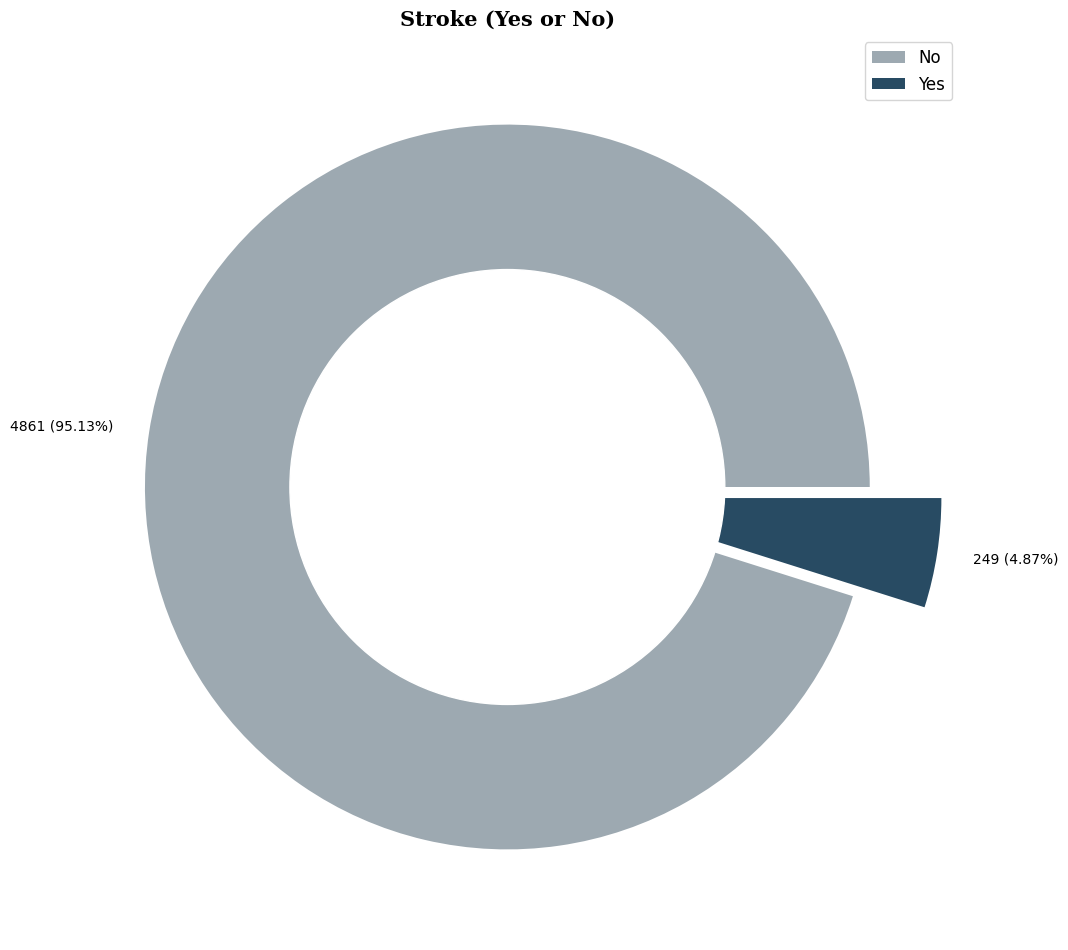

In [ ]:
stroke = df.groupby(["stroke"], as_index=False).agg(Count=("id", "count"))
stroke["%"] = (stroke.iloc[:, -1] / stroke.iloc[:, -1].sum()) * 100

fig = plt.figure(figsize=(12, 12), dpi=100)

explode = np.zeros(len(stroke))
explode[1] = 0.2
explode = tuple(explode)

plt.pie(
    stroke["%"],
    explode = explode,
    labels = [
        f"{j} ({round(i, 2)}%)"
        for i, j in zip(list(stroke["%"]), list(stroke["Count"]))
    ],
    colors=["#9DA9B1", "#284B63"]
)
plt.gcf().gca().add_artist(plt.Circle( (0,0), 0.6, color="white"))
plt.title(
    "Stroke (Yes or No)", fontsize=15,
    fontweight="bold", fontfamily="serif"
)
plt.legend(labels=["No", "Yes"], fontsize=12)

## **b. Distribution of Numerical Features**

- Age, BMI, and Average Gluose Level Features

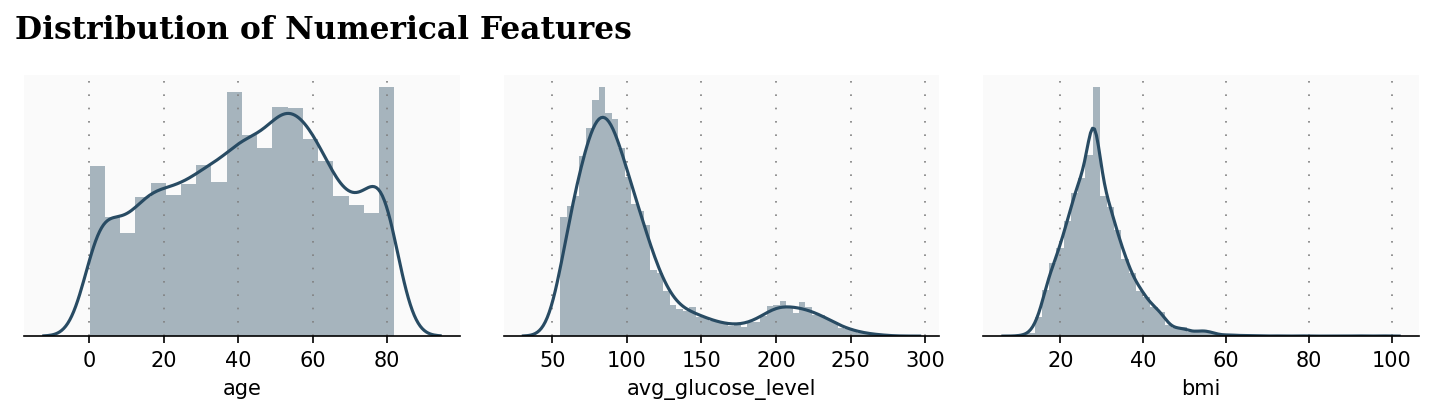

In [ ]:
fig = plt.figure(figsize=(12, 12), dpi=150)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()['ax'+str(plot)] = fig.add_subplot(gs[row, col])
        locals()['ax'+str(plot)].set_facecolor('#fafafa')
        locals()['ax'+str(plot)].tick_params(axis='y', left=False)
        locals()['ax'+str(plot)].get_yaxis().set_visible(False)
        for s in ['top','right','left']:
            locals()['ax'+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0
for variable in ["age", "avg_glucose_level", "bmi"]:
        sns.distplot(df[variable], ax=locals()['ax'+str(plot)], color='#284B63')
        locals()['ax'+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,7))
        plot += 1

fig.text(.12, .90, 'Distribution of Numerical Features', fontsize=15, fontweight='bold', fontfamily='serif')

plt.tight_layout()
plt.show()

- Age, BMI, and Average Gluose Level Features by Stroke

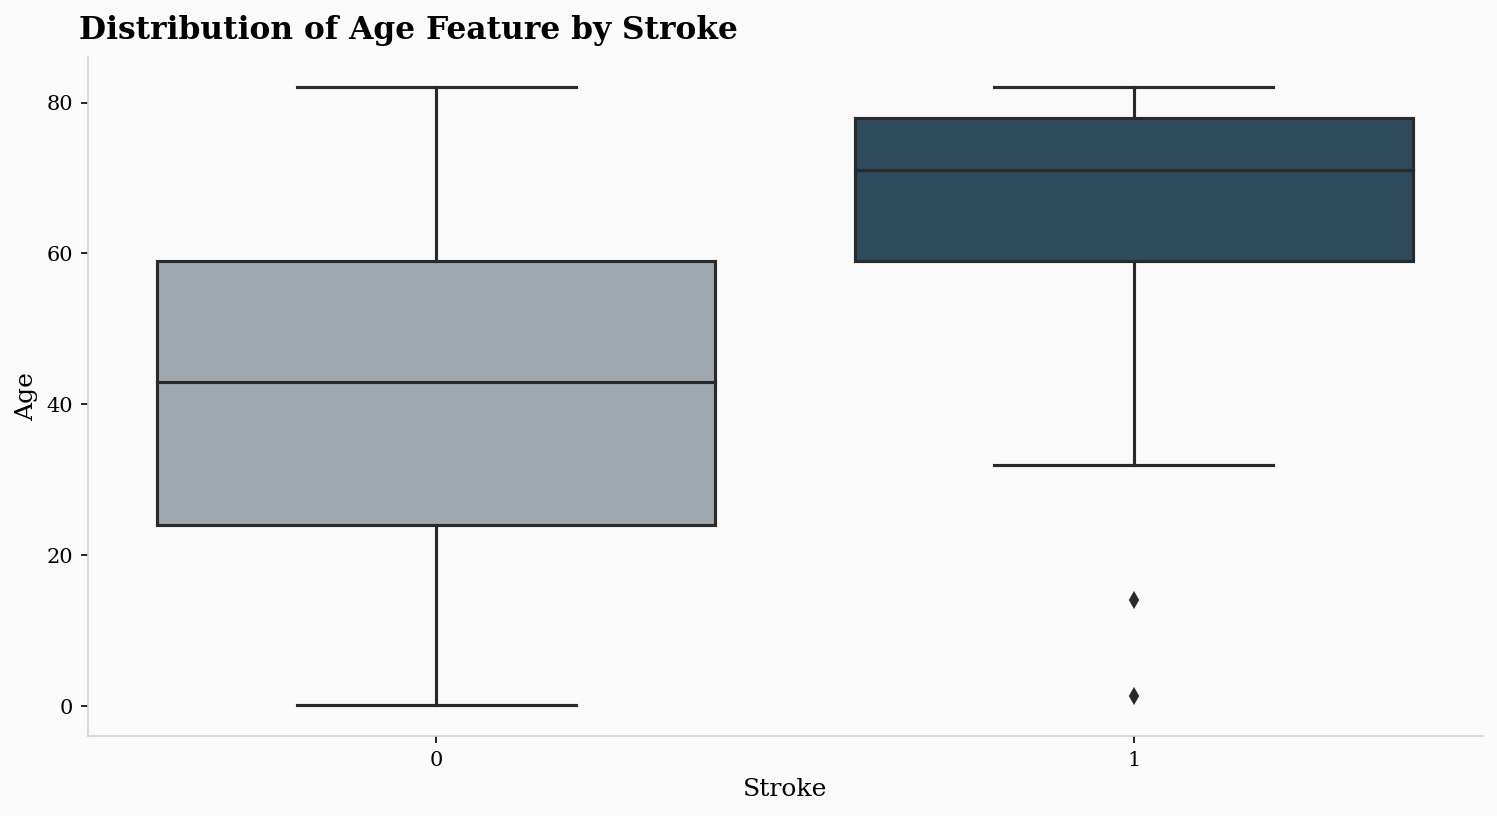

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

ax.spines['bottom'].set_color('lightgray')
ax.spines['left'].set_color('lightgray')

ax.set_axisbelow(True)

palette = ['#9DA9B1', '#284B63']
ax = sns.boxplot(x='stroke', y='age', data=df, palette=palette)

background_color = "#fafafa"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

plt.yticks(fontfamily='serif',fontweight='light')
plt.xticks(fontfamily='serif',fontweight='light')

ax.set_ylabel('Age',fontfamily='serif',fontsize=12)
ax.set_xlabel('Stroke',fontfamily='serif',fontsize=12)

fig.text(.12, .90, 'Distribution of Age Feature by Stroke', fontsize=15, fontweight='bold', fontfamily='serif')

plt.show()

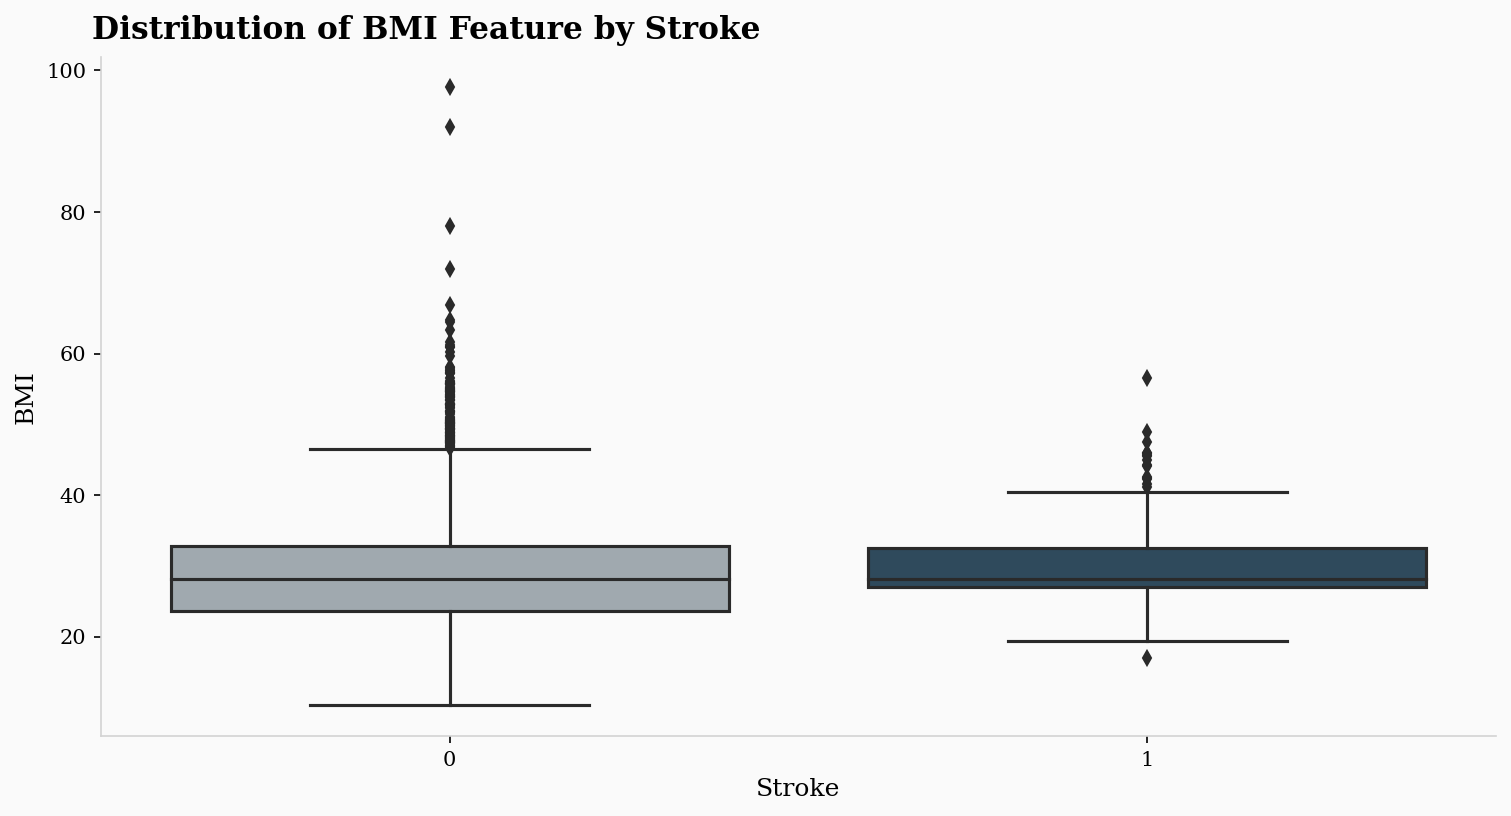

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

ax.spines['bottom'].set_color('lightgray')
ax.spines['left'].set_color('lightgray')

ax.set_axisbelow(True)

palette = ['#9DA9B1', '#284B63']
ax = sns.boxplot(x='stroke', y='bmi', data=df, palette=palette)

background_color = "#fafafa"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

plt.yticks(fontfamily='serif',fontweight='light')
plt.xticks(fontfamily='serif',fontweight='light')

ax.set_ylabel('BMI',fontfamily='serif',fontsize=12)
ax.set_xlabel('Stroke',fontfamily='serif',fontsize=12)

fig.text(.12, .90, 'Distribution of BMI Feature by Stroke', fontsize=15, fontweight='bold', fontfamily='serif')

plt.show()

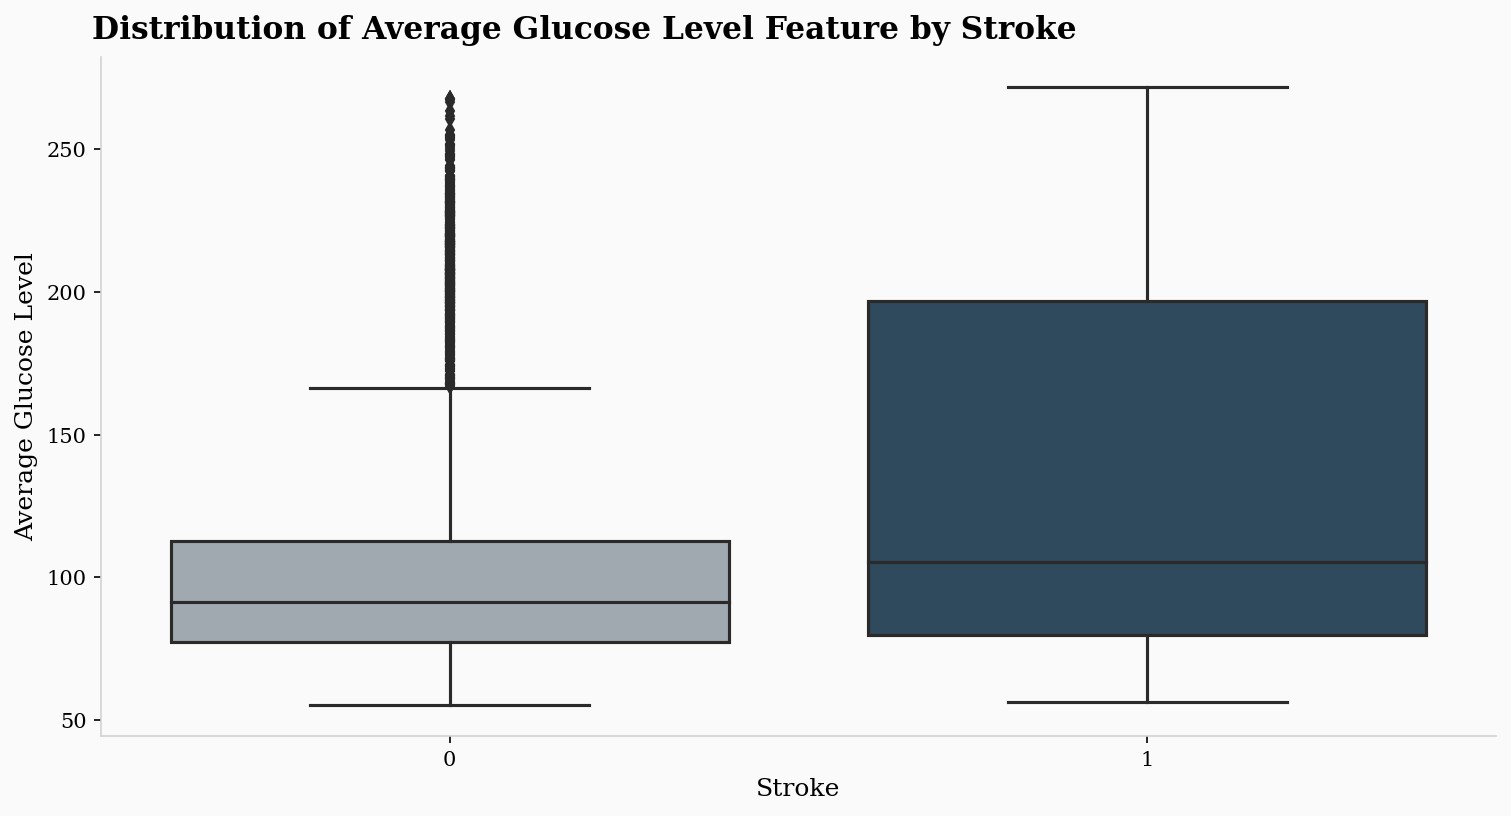

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

ax.spines['bottom'].set_color('lightgray')
ax.spines['left'].set_color('lightgray')

ax.set_axisbelow(True)

palette = ['#9DA9B1', '#284B63']
ax = sns.boxplot(x='stroke', y='avg_glucose_level', data=df, palette=palette)

background_color = "#fafafa"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

plt.yticks(fontfamily='serif',fontweight='light')
plt.xticks(fontfamily='serif',fontweight='light')

ax.set_ylabel('Average Glucose Level',fontfamily='serif',fontsize=12)
ax.set_xlabel('Stroke',fontfamily='serif',fontsize=12)

fig.text(.12, .90, 'Distribution of Average Glucose Level Feature by Stroke', fontsize=15, fontweight='bold', fontfamily='serif')

plt.show()

- Correlation between Age and BMI

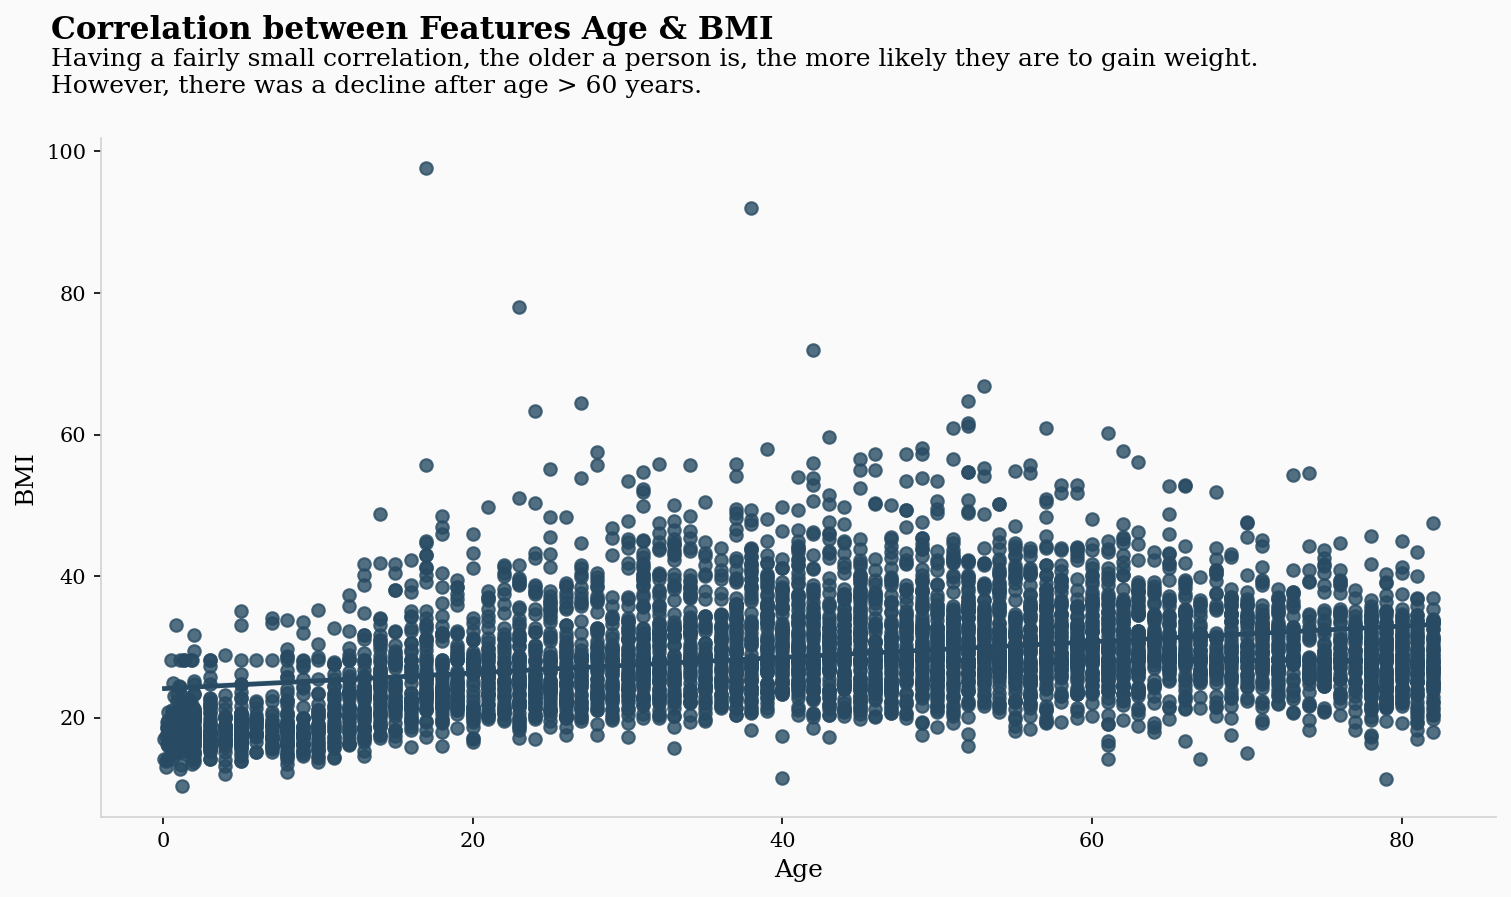

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

fig.text(.097, .99,'Correlation between Features Age & BMI', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(.097, .93,'Having a fairly small correlation, the older a person is, the more likely they are to gain weight.\nHowever, there was a decline after age > 60 years.',fontfamily='serif',fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

ax.spines['bottom'].set_color('lightgray')
ax.spines['left'].set_color('lightgray')

ax.set_axisbelow(True)

sns.regplot(y = 'bmi' , x = 'age' , data = df ,color='#284B63')

background_color = "#fafafa"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

plt.yticks(fontfamily='serif',fontweight='light')
plt.xticks(fontfamily='serif',fontweight='light')

ax.set_ylabel('BMI',fontfamily='serif',fontsize=12)
ax.set_xlabel('Age',fontfamily='serif',fontsize=12)

plt.show()

- Correlation between Age and Average Glucose Level

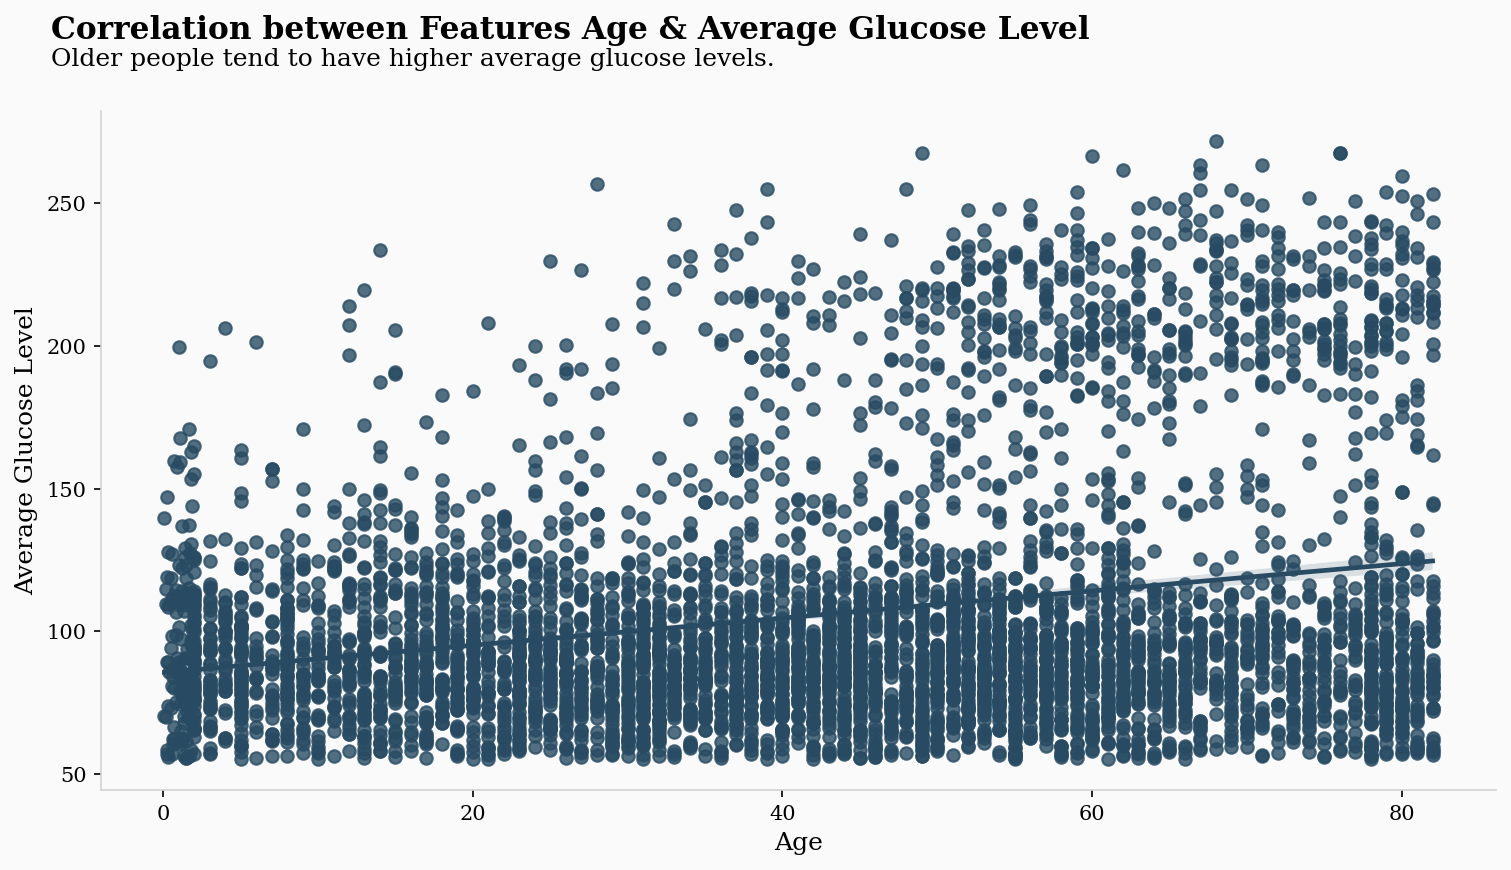

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

fig.text(.097, .96,'Correlation between Features Age & Average Glucose Level', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(.097, .93,'Older people tend to have higher average glucose levels.',fontfamily='serif',fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)


ax.spines['bottom'].set_color('lightgray')
ax.spines['left'].set_color('lightgray')

ax.set_axisbelow(True)

sns.regplot(y = 'avg_glucose_level' , x = 'age' , data = df ,color='#284B63')

background_color = "#fafafa"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

plt.yticks(fontfamily='serif',fontweight='light')
plt.xticks(fontfamily='serif',fontweight='light')

ax.set_ylabel('Average Glucose Level',fontfamily='serif',fontsize=12)
ax.set_xlabel('Age',fontfamily='serif',fontsize=12)

plt.show()

- Correlation between Average Glucose Level and BMI

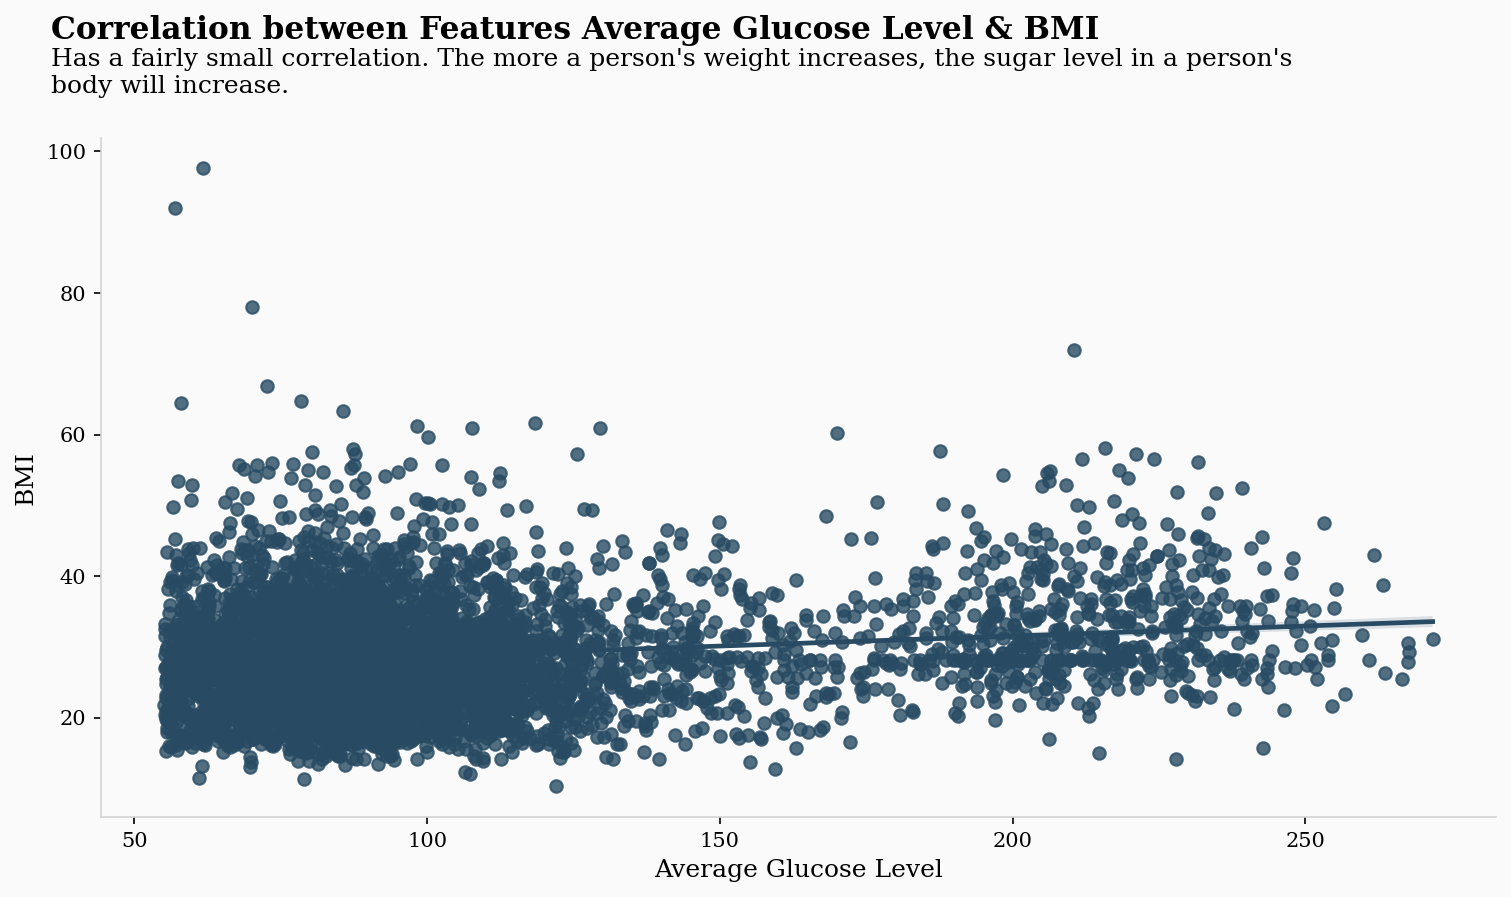

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

fig.text(.097, .99,'Correlation between Features Average Glucose Level & BMI', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(.097, .93,"Has a fairly small correlation. The more a person's weight increases, the sugar level in a person's\nbody will increase.",fontfamily='serif',fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)


ax.spines['bottom'].set_color('lightgray')
ax.spines['left'].set_color('lightgray')

ax.set_axisbelow(True)

sns.regplot(x = 'avg_glucose_level' , y = 'bmi' , data = df ,color='#284B63')

background_color = "#fafafa"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

plt.yticks(fontfamily='serif',fontweight='light')
plt.xticks(fontfamily='serif',fontweight='light')

ax.set_xlabel('Average Glucose Level',fontfamily='serif',fontsize=12)
ax.set_ylabel('BMI',fontfamily='serif',fontsize=12)

plt.show()

## **c. Gender**

In [ ]:
def plot_categorical_by_target(df, col_count, col_feature, target):
  res = df.groupby([col_feature, target]).agg({col_count: "count"}).unstack().reset_index()
  res.columns = res.columns.map("{0[0]} {0[1]}".format)
  res.columns = [c.strip() for c in res.columns]
  res.iloc[:, :].fillna(0, inplace=True)
  res["total"] = res.iloc[:, -2:].sum(axis=1)
  res[f"percentage of patient"] = round(res.iloc[:, -1] / df[col_count].count() * 100, 2)
  res["percentage of stroke"] = round(res.iloc[:, -3] / res.iloc[:, -2] * 100, 2)
  res = res.sort_values("total", ascending=False, ignore_index=True)

  return res

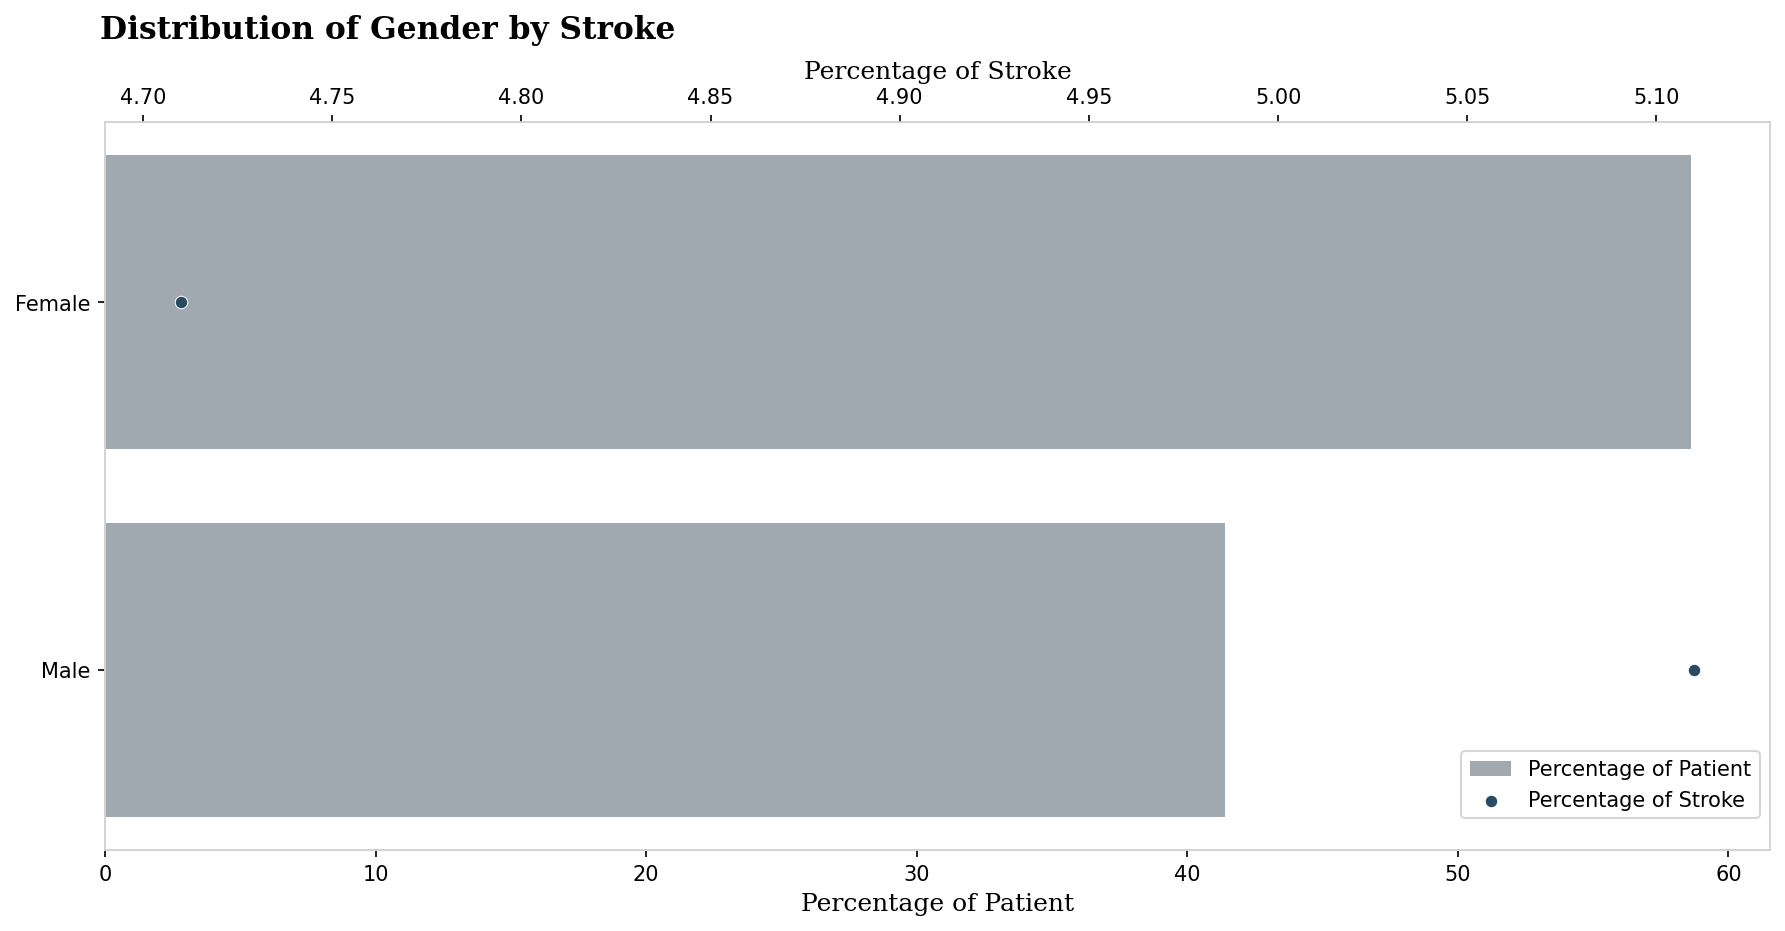

In [ ]:
res = plot_categorical_by_target(df, "id", "gender", "stroke")

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
graph1 = sns.barplot(x="percentage of patient", y=res.columns[0], data=res, palette=["#9DA9B1"], ax=ax, label="Percentage of Patient").set(xlabel="Percentage of Patient")

ax2=ax.twiny()
ax2.grid(False)

graph2 = sns.scatterplot(data=res, x="percentage of stroke", y=res.columns[0], ax=ax2, color="#284B63", label="Percentage of Stroke").set(xlabel="Percentage of Stroke")

for t in ['left', 'bottom', 'top', 'right']:
    ax.spines[t].set_color('lightgray')
    ax2.spines[t].set_color('lightgray')

ax2.legend().set_visible(False)
fig.legend(loc="best",bbox_to_anchor=(1, 0.15),bbox_transform=ax.transAxes)

ax.set_ylabel("")
ax.set_xlabel('Percentage of Patient', fontsize=12, fontweight='light', fontfamily='serif')
ax2.set_xlabel('Percentage of Stroke', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(.06, 1,'Distribution of Gender by Stroke', fontfamily='serif',fontsize=15, fontweight='bold')

plt.tight_layout()

## **d. Hypertension**

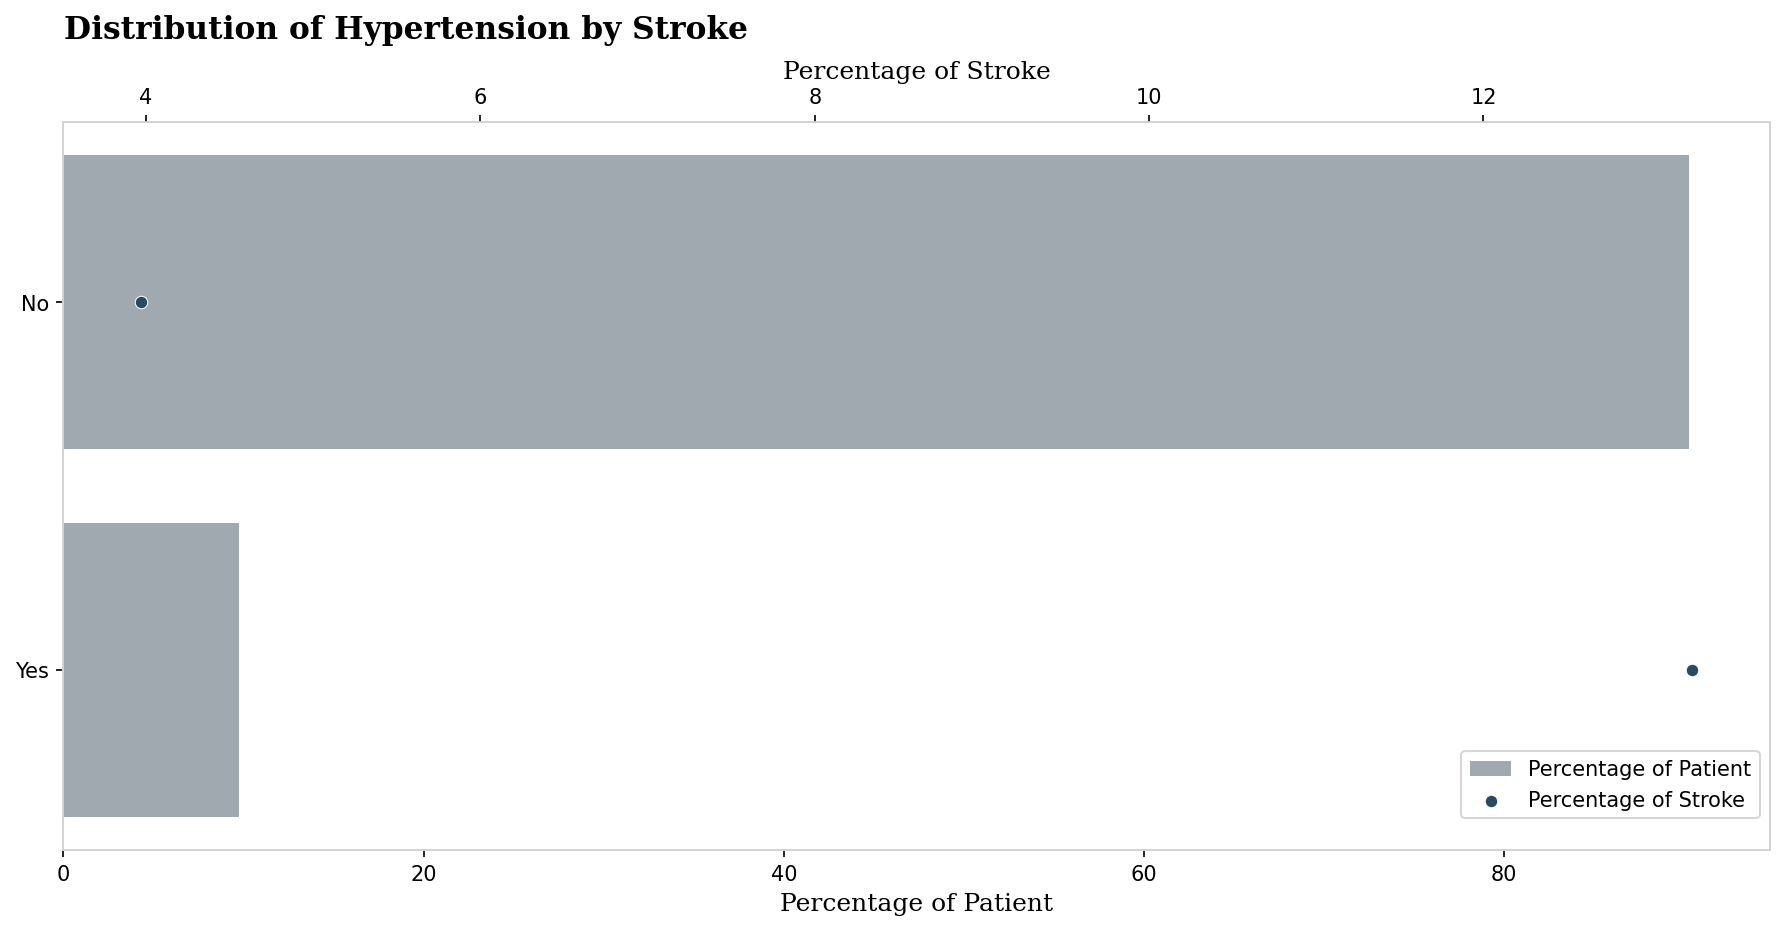

In [ ]:
res = plot_categorical_by_target(df, "id", "hypertension", "stroke")
res["hypertension"] = res["hypertension"].replace({0: "No", 1: "Yes"})

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
graph1 = sns.barplot(x="percentage of patient", y=res.columns[0], data=res, palette=["#9DA9B1"], ax=ax, label="Percentage of Patient").set(xlabel="Percentage of Patient")

ax2=ax.twiny()
ax2.grid(False)

graph2 = sns.scatterplot(data=res, x="percentage of stroke", y=res.columns[0], ax=ax2, color="#284B63", label="Percentage of Stroke").set(xlabel="Percentage of Stroke")

for t in ['left', 'bottom', 'top', 'right']:
    ax.spines[t].set_color('lightgray')
    ax2.spines[t].set_color('lightgray')

ax2.legend().set_visible(False)
fig.legend(loc="best",bbox_to_anchor=(1, 0.15),bbox_transform=ax.transAxes)

ax.set_ylabel("")
ax.set_xlabel('Percentage of Patient', fontsize=12, fontweight='light', fontfamily='serif')
ax2.set_xlabel('Percentage of Stroke', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(.04, 1,'Distribution of Hypertension by Stroke', fontfamily='serif',fontsize=15, fontweight='bold')

plt.tight_layout()

## **e. Heart Disease**

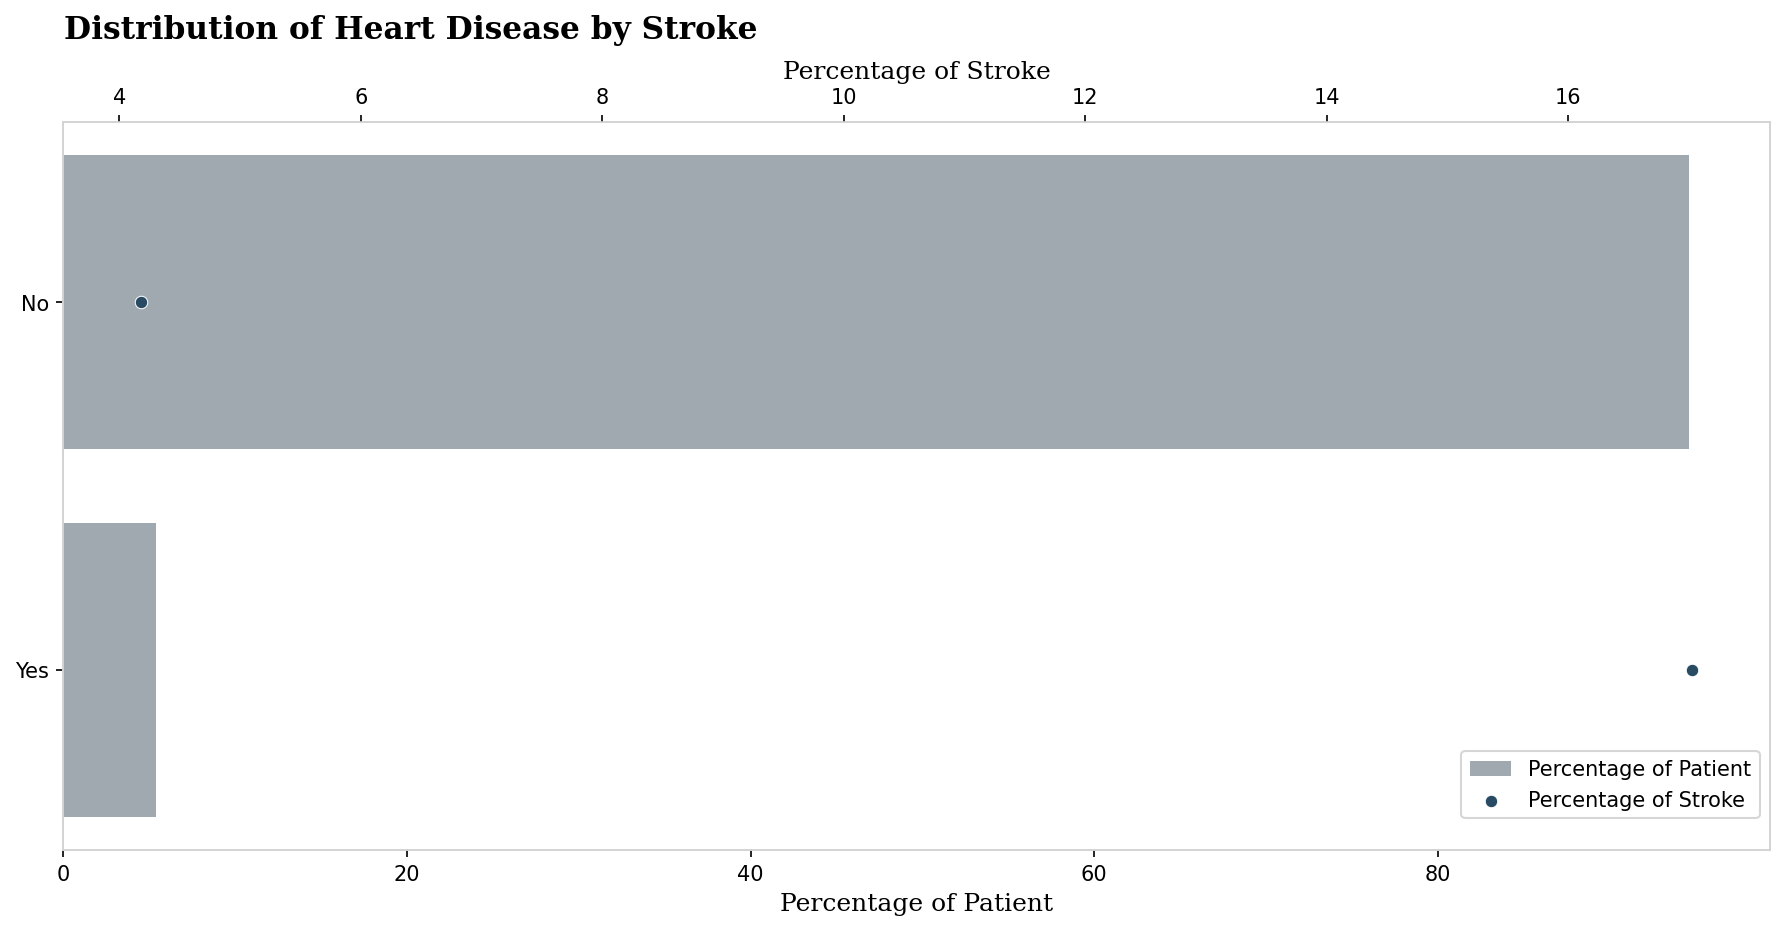

In [ ]:
res = plot_categorical_by_target(df, "id", "heart_disease", "stroke")
res["heart_disease"] = res["heart_disease"].replace({0: "No", 1: "Yes"})

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
graph1 = sns.barplot(x="percentage of patient", y=res.columns[0], data=res, palette=["#9DA9B1"], ax=ax, label="Percentage of Patient").set(xlabel="Percentage of Patient")

ax2=ax.twiny()
ax2.grid(False)

graph2 = sns.scatterplot(data=res, x="percentage of stroke", y=res.columns[0], ax=ax2, color="#284B63", label="Percentage of Stroke").set(xlabel="Percentage of Stroke")

for t in ['left', 'bottom', 'top', 'right']:
    ax.spines[t].set_color('lightgray')
    ax2.spines[t].set_color('lightgray')

ax2.legend().set_visible(False)
fig.legend(loc="best",bbox_to_anchor=(1, 0.15),bbox_transform=ax.transAxes)

ax.set_ylabel("")
ax.set_xlabel('Percentage of Patient', fontsize=12, fontweight='light', fontfamily='serif')
ax2.set_xlabel('Percentage of Stroke', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(.04, 1,'Distribution of Heart Disease by Stroke', fontfamily='serif',fontsize=15, fontweight='bold')

plt.tight_layout()

## **f. Ever Married**

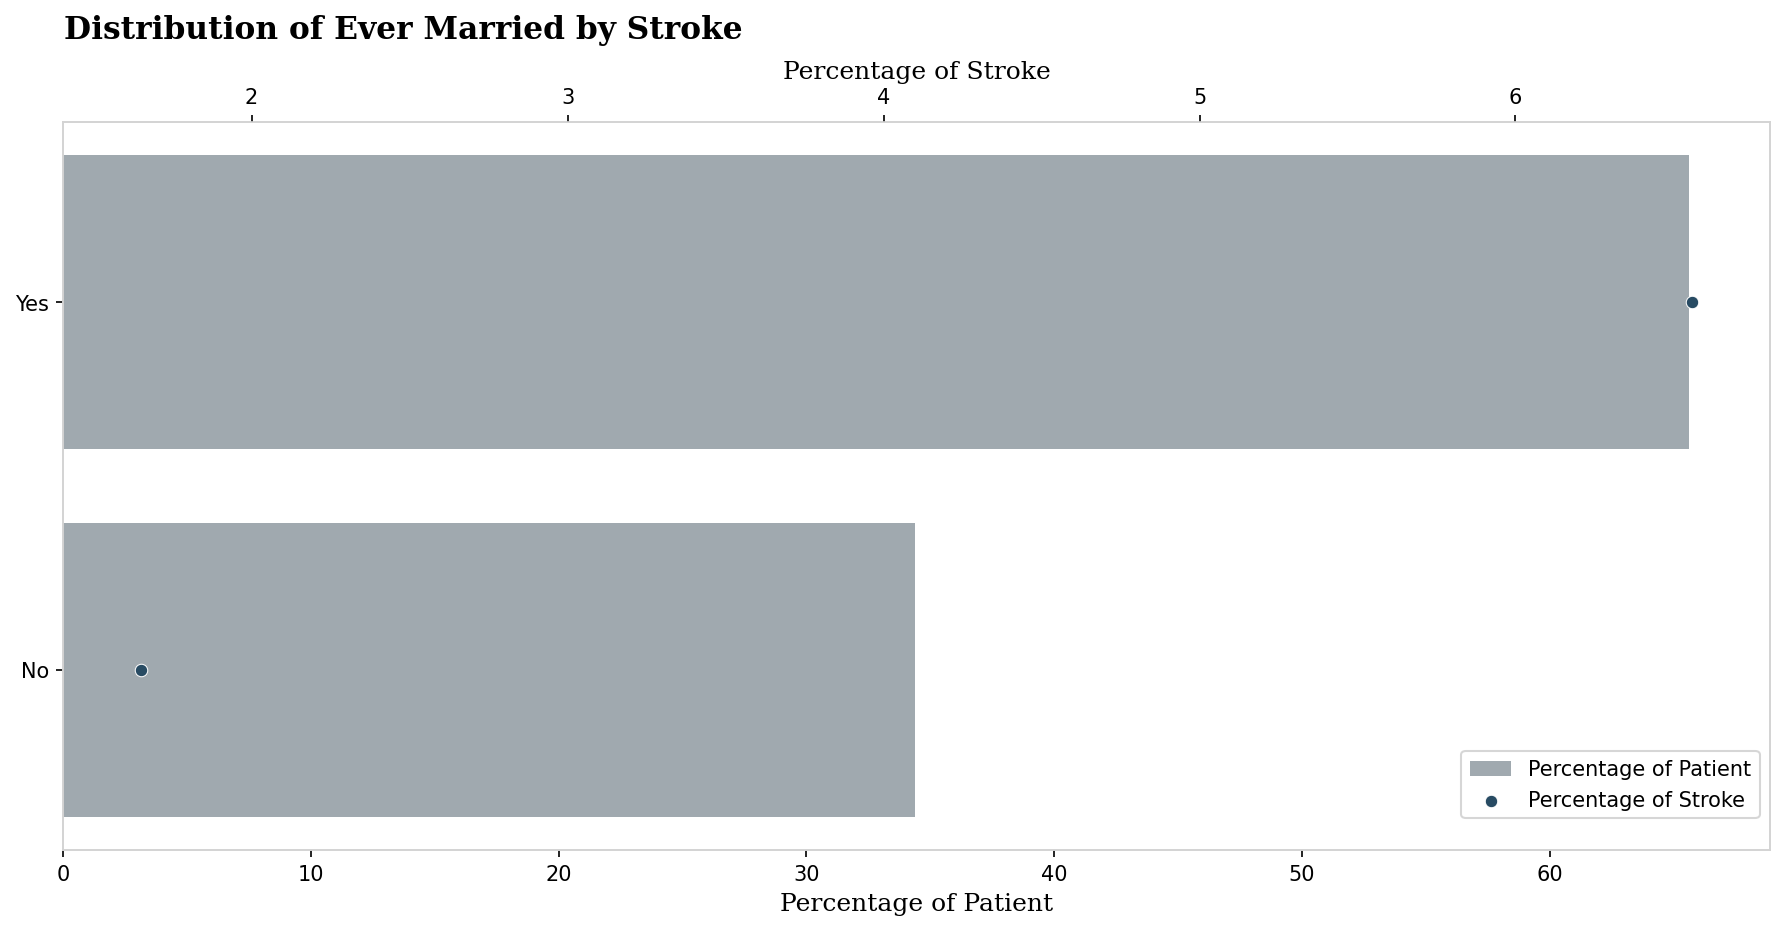

In [ ]:
res = plot_categorical_by_target(df, "id", "ever_married", "stroke")

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
graph1 = sns.barplot(x="percentage of patient", y=res.columns[0], data=res, palette=["#9DA9B1"], ax=ax, label="Percentage of Patient").set(xlabel="Percentage of Patient")

ax2=ax.twiny()
ax2.grid(False)

graph2 = sns.scatterplot(data=res, x="percentage of stroke", y=res.columns[0], ax=ax2, color="#284B63", label="Percentage of Stroke").set(xlabel="Percentage of Stroke")

for t in ['left', 'bottom', 'top', 'right']:
    ax.spines[t].set_color('lightgray')
    ax2.spines[t].set_color('lightgray')

ax2.legend().set_visible(False)
fig.legend(loc="best",bbox_to_anchor=(1, 0.15),bbox_transform=ax.transAxes)

ax.set_ylabel("")
ax.set_xlabel('Percentage of Patient', fontsize=12, fontweight='light', fontfamily='serif')
ax2.set_xlabel('Percentage of Stroke', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(.04, 1,'Distribution of Ever Married by Stroke', fontfamily='serif',fontsize=15, fontweight='bold')

plt.tight_layout()

## **g. Working Status**

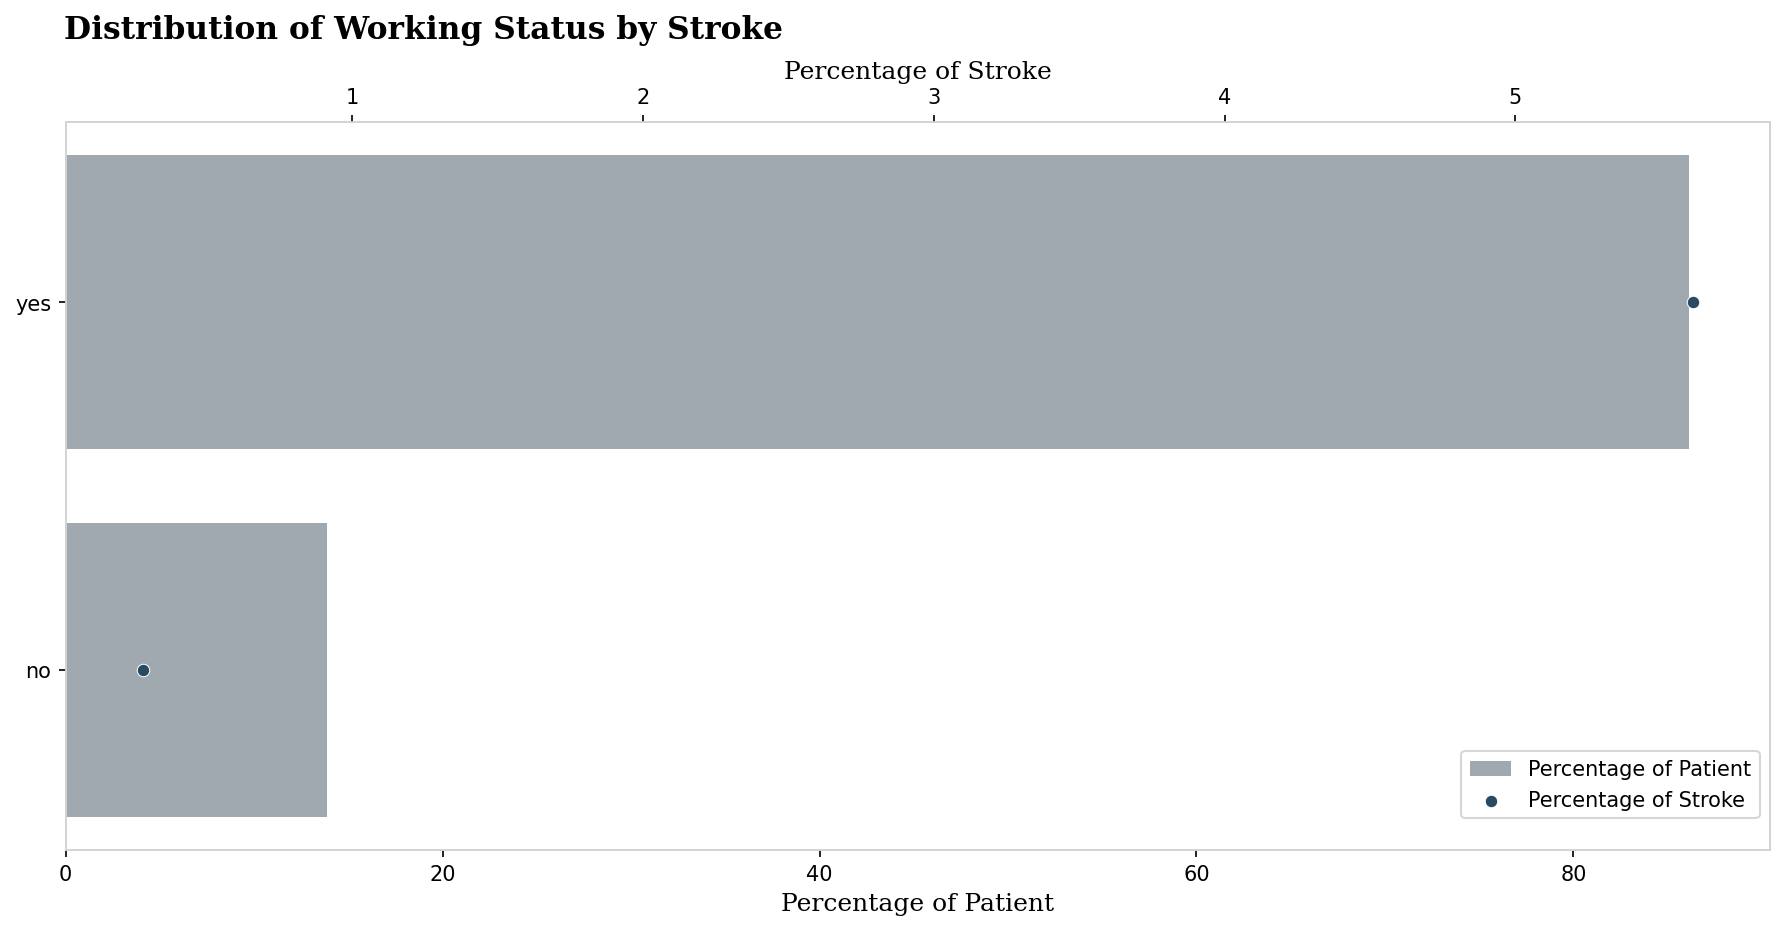

In [ ]:
res = plot_categorical_by_target(df, "id", "working_status", "stroke")

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
graph1 = sns.barplot(x="percentage of patient", y=res.columns[0], data=res, palette=["#9DA9B1"], ax=ax, label="Percentage of Patient").set(xlabel="Percentage of Patient")

ax2=ax.twiny()
ax2.grid(False)

graph2 = sns.scatterplot(data=res, x="percentage of stroke", y=res.columns[0], ax=ax2, color="#284B63", label="Percentage of Stroke").set(xlabel="Percentage of Stroke")

for t in ['left', 'bottom', 'top', 'right']:
    ax.spines[t].set_color('lightgray')
    ax2.spines[t].set_color('lightgray')

ax2.legend().set_visible(False)
fig.legend(loc="best",bbox_to_anchor=(1, 0.15),bbox_transform=ax.transAxes)

ax.set_ylabel("")
ax.set_xlabel('Percentage of Patient', fontsize=12, fontweight='light', fontfamily='serif')
ax2.set_xlabel('Percentage of Stroke', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(.04, 1,'Distribution of Working Status by Stroke', fontfamily='serif',fontsize=15, fontweight='bold')

plt.tight_layout()

## **h. Residence Type**

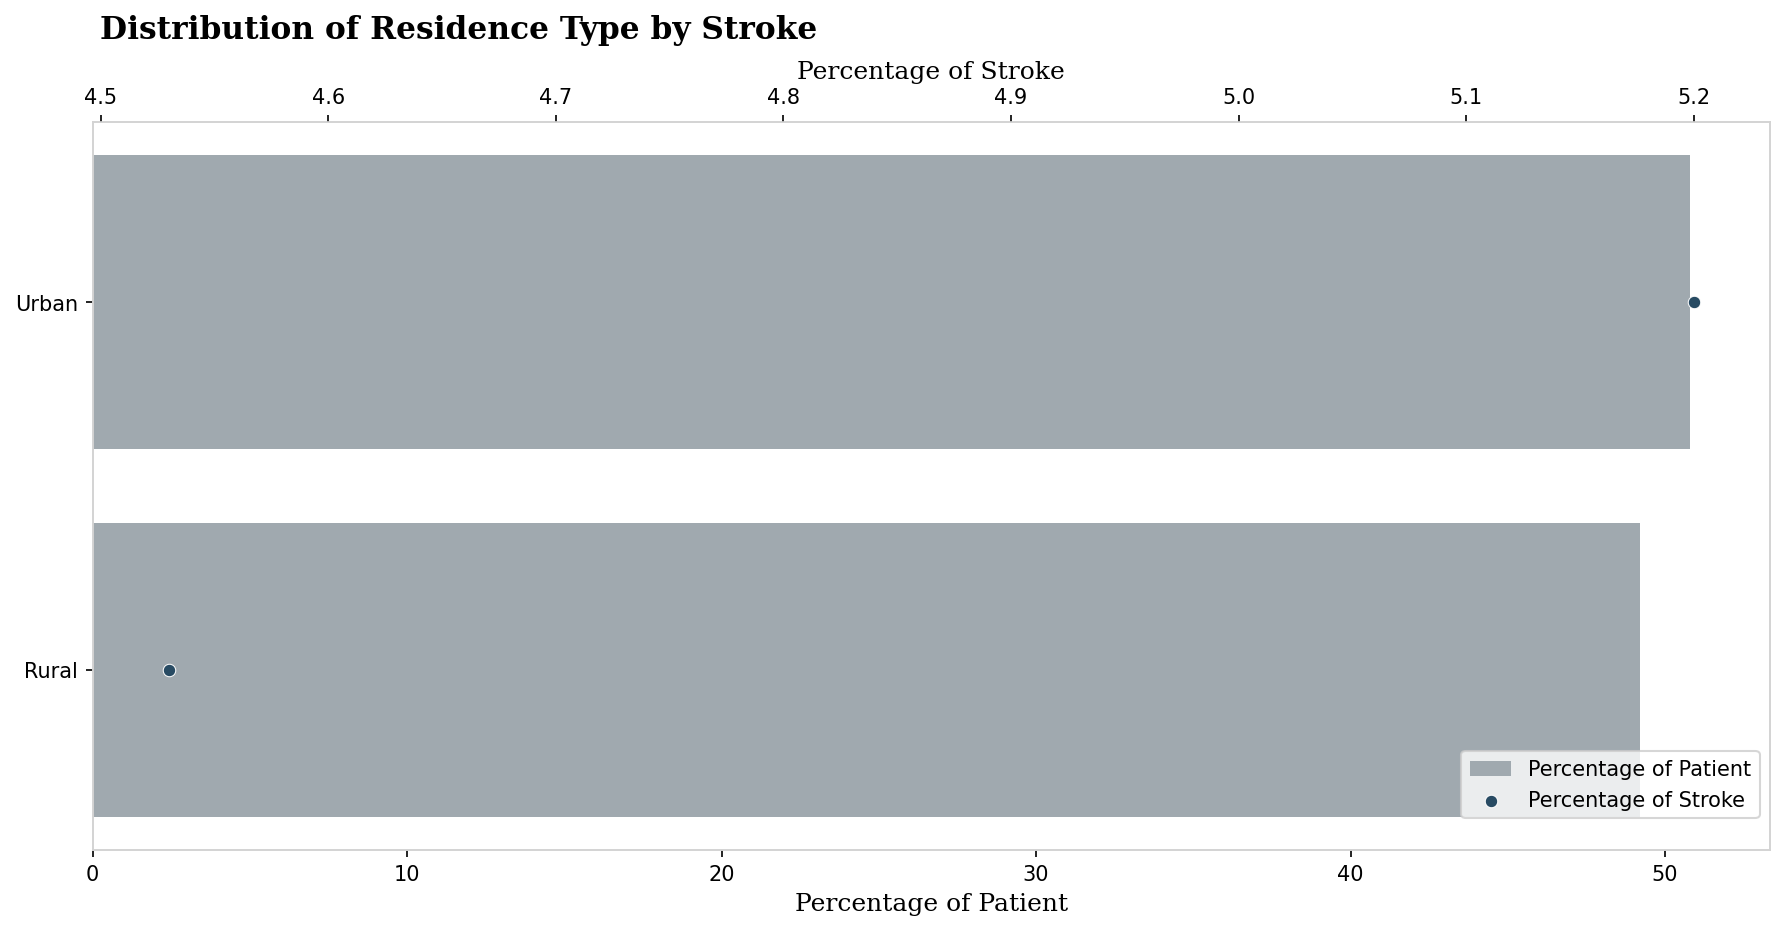

In [ ]:
res = plot_categorical_by_target(df, "id", "Residence_type", "stroke")

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
graph1 = sns.barplot(x="percentage of patient", y=res.columns[0], data=res, palette=["#9DA9B1"], ax=ax, label="Percentage of Patient").set(xlabel="Percentage of Patient")

ax2=ax.twiny()
ax2.grid(False)

graph2 = sns.scatterplot(data=res, x="percentage of stroke", y=res.columns[0], ax=ax2, color="#284B63", label="Percentage of Stroke").set(xlabel="Percentage of Stroke")

for t in ['left', 'bottom', 'top', 'right']:
    ax.spines[t].set_color('lightgray')
    ax2.spines[t].set_color('lightgray')

ax2.legend().set_visible(False)
fig.legend(loc="best",bbox_to_anchor=(1, 0.15),bbox_transform=ax.transAxes)

ax.set_ylabel("")
ax.set_xlabel('Percentage of Patient', fontsize=12, fontweight='light', fontfamily='serif')
ax2.set_xlabel('Percentage of Stroke', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(.06, 1,'Distribution of Residence Type by Stroke', fontfamily='serif',fontsize=15, fontweight='bold')

plt.tight_layout()

## **i. Smoking Status**

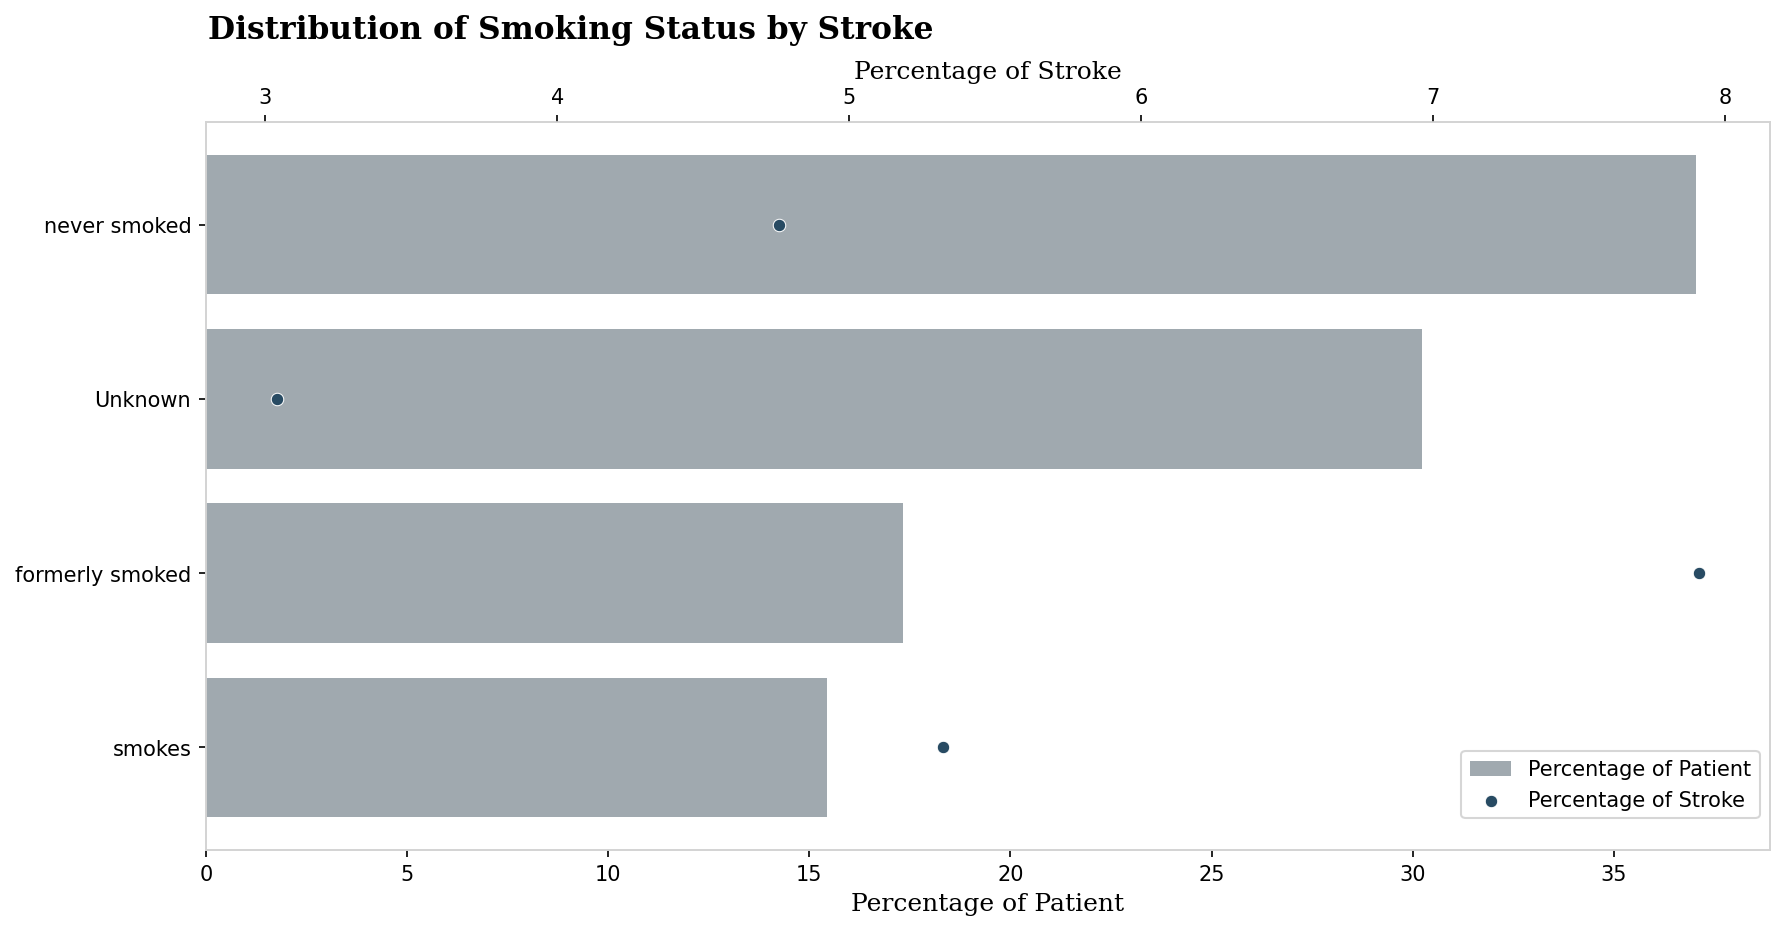

In [ ]:
res = plot_categorical_by_target(df, "id", "smoking_status", "stroke")

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
graph1 = sns.barplot(x="percentage of patient", y=res.columns[0], data=res, palette=["#9DA9B1"], ax=ax, label="Percentage of Patient").set(xlabel="Percentage of Patient")

ax2=ax.twiny()
ax2.grid(False)

graph2 = sns.scatterplot(data=res, x="percentage of stroke", y=res.columns[0], ax=ax2, color="#284B63", label="Percentage of Stroke").set(xlabel="Percentage of Stroke")

for t in ['left', 'bottom', 'top', 'right']:
    ax.spines[t].set_color('lightgray')
    ax2.spines[t].set_color('lightgray')

ax2.legend().set_visible(False)
fig.legend(loc="best",bbox_to_anchor=(1, 0.15),bbox_transform=ax.transAxes)

ax.set_ylabel("")
ax.set_xlabel('Percentage of Patient', fontsize=12, fontweight='light', fontfamily='serif')
ax2.set_xlabel('Percentage of Stroke', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(.12, 1,'Distribution of Smoking Status by Stroke', fontfamily='serif',fontsize=15, fontweight='bold')

plt.tight_layout()

# **VII. Feature Engineering**

Will do:

- Removed the `id` column.
- Cleaning outliers in the `bmi` and `avg_glucose_level` features. After that, check again about the distribution.
- Perform Feature Encoding for categorical features.
- Perform normalization/standardization for numerical features.
- Unbalanced data handling.

In [15]:
df_feature = df.copy()

## **a. Delete Unnecessary Columns**

In [16]:
df_feature.drop(columns="id", inplace=True)
df_feature.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'working_status', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

## **b. Cleaning Outliers**

Using Z-Scores

In [17]:
print(f"Data Before Cleaning Outliers on BMI Feature: {df_feature.shape[0]}")
print(f"Stroke ratio:\n{df_feature['stroke'].value_counts()}")

for i in ["bmi", "avg_glucose_level"]:
  z_scores = np.abs(stats.zscore(df_feature[i]))
  filtered_entries = z_scores < 3
  df_feature = df_feature[filtered_entries]

print("="*50)
print(f"Data After Cleaning Outliers on BMI Feature: {df_feature.shape[0]}")
print(f"Stroke ratio:\n{df_feature['stroke'].value_counts()}")

Data Before Cleaning Outliers on BMI Feature: 5110
Stroke ratio:
0    4861
1     249
Name: stroke, dtype: int64
Data After Cleaning Outliers on BMI Feature: 5002
Stroke ratio:
0    4763
1     239
Name: stroke, dtype: int64


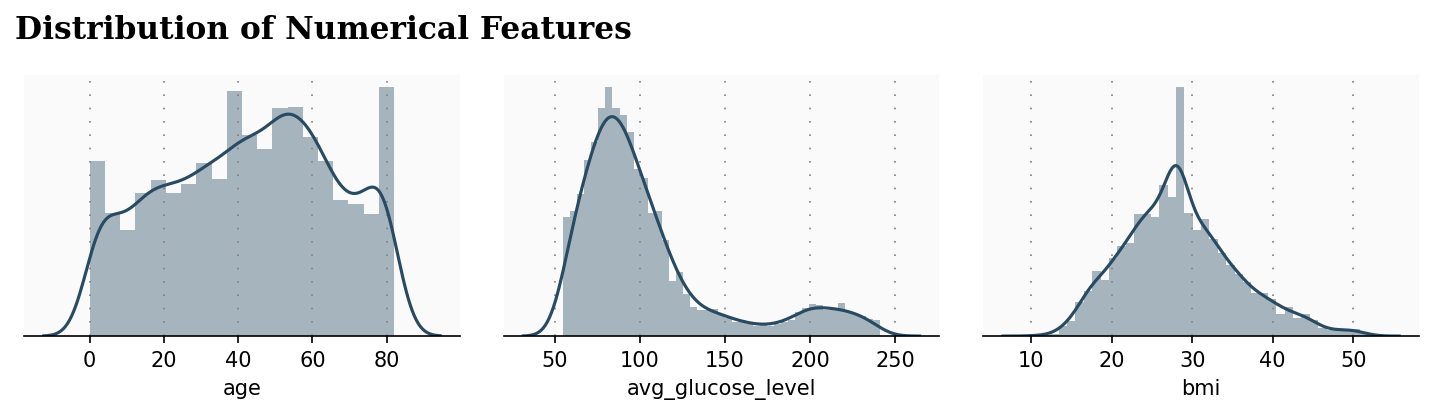

In [18]:
fig = plt.figure(figsize=(12, 12), dpi=150)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()['ax'+str(plot)] = fig.add_subplot(gs[row, col])
        locals()['ax'+str(plot)].set_facecolor('#fafafa')
        locals()['ax'+str(plot)].tick_params(axis='y', left=False)
        locals()['ax'+str(plot)].get_yaxis().set_visible(False)
        for s in ['top','right','left']:
            locals()['ax'+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0
for variable in ["age", "avg_glucose_level", "bmi"]:
        sns.distplot(df_feature[variable], ax=locals()['ax'+str(plot)], color='#284B63')
        locals()['ax'+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,7))
        plot += 1

fig.text(.12, .90, 'Distribution of Numerical Features', fontsize=15, fontweight='bold', fontfamily='serif')

plt.tight_layout()
plt.show()

## **c. Feature Encoding**

In [19]:
map_gender = {
    "Female": 0,
    "Male": 1,
}

map_ever_married = {
    "Yes": 1,
    "No": 0,
}

map_working_status = {
    "yes": 1,
    "no": 0,
}

map_residence_type = {
    "Urban": 1,
    "Rural": 0,
}

map_smoking_status = {
    "never smoked": 0,
    "Unknown": 1,
    "formerly smoked": 2,
    "smokes": 3,
}

df_feature["gender"] = df_feature["gender"].map(map_gender)
df_feature["ever_married"] = df_feature["ever_married"].map(map_ever_married)
df_feature["working_status"] = df_feature["working_status"].map(map_working_status)
df_feature["Residence_type"] = df_feature["Residence_type"].map(map_residence_type)
df_feature["smoking_status"] = df_feature["smoking_status"].map(map_smoking_status)

## **d. Feature Transformation**

In [20]:
for i in ["age", "avg_glucose_level", "bmi"]:
  if i == "age":
    df_feature[str(i) + '_norm'] = MinMaxScaler().fit_transform(df_feature[str(i)].values.reshape(len(df_feature), 1))
    df_feature = df_feature.drop(columns = str(i))
  else:
    df_feature[str(i) + '_std'] = StandardScaler().fit_transform(df_feature[str(i)].values.reshape(len(df_feature), 1))
    df_feature = df_feature.drop(columns = str(i))

Text(0.5, 1.0, 'Correlation')

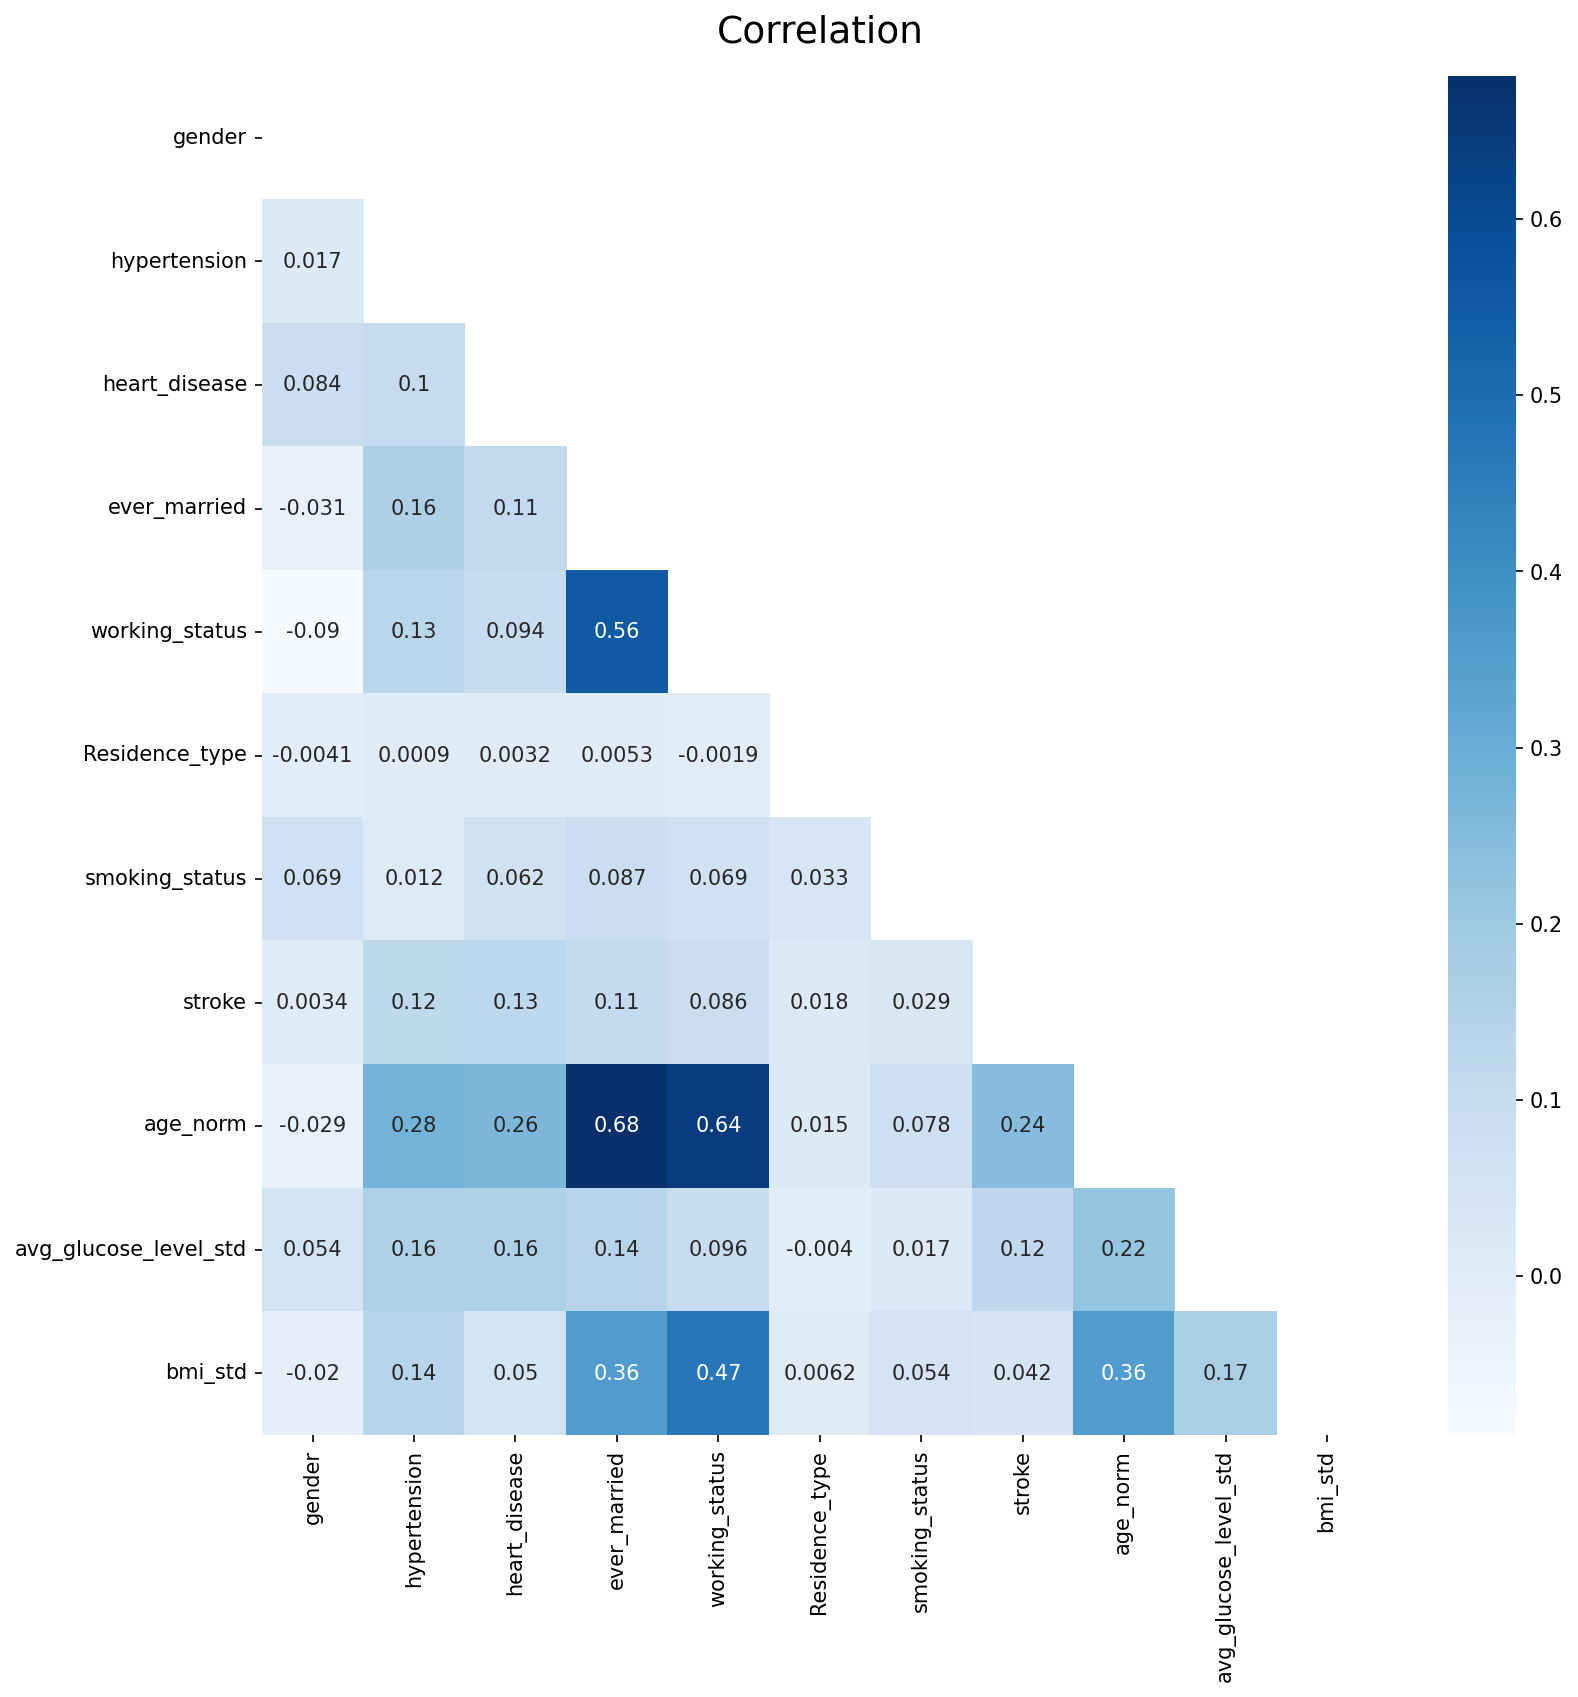

In [21]:
fig = plt.figure(figsize=(12, 12), dpi=150)

mask = np.triu(np.ones_like(df_feature.corr(), dtype=np.bool))

heatmap = sns.heatmap(df_feature.corr(), mask=mask, annot=True, cmap='Blues' )
heatmap.set_title('Correlation', fontdict={'fontsize':18}, pad=16)

In [22]:
df_feature

,gender,hypertension,heart_disease,ever_married,working_status,Residence_type,smoking_status,stroke,age_norm,avg_glucose_level_std,bmi_std
0,1,0,1,1,1,1,2,1,0.816895,2.894885,1.158988
1,0,0,0,1,1,0,0,1,0.743652,2.277464,-0.055828
2,1,0,1,1,1,0,0,1,0.975586,0.032321,0.573018
3,0,0,0,1,1,1,3,1,0.597168,1.555120,0.844565
4,0,1,0,1,1,0,0,1,0.963379,1.622505,-0.641797
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,1,0,1,1,1,0,0,0.975586,-0.484605,-0.055828
5106,0,0,0,1,1,1,0,0,0.987793,0.481863,1.644914
5107,0,0,0,1,1,0,0,0,0.426270,-0.502326,0.301471
5108,1,0,0,1,1,0,2,0,0.621582,1.439937,-0.413126


## **e. Handling Data Imbalance**

In [ ]:
X = df_feature.drop(columns=['stroke'])
y = df_feature['stroke']
print(X.shape)
print(y.shape)

(5002, 10)
(5002,)


In [ ]:
X_train, y_train = over_sampling.SMOTE(.45, random_state=42).fit_resample(X, y)

print('Original')
print(pd.Series(y).value_counts())

print('')
print('SMOTE')
print(pd.Series(y_train).value_counts())

Original
0    4763
1     239
Name: stroke, dtype: int64

SMOTE
0    4763
1    2143
Name: stroke, dtype: int64


# **VIII. Modeling**

## **a. Split Train & Test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

## **b. Find Best Model**

In [ ]:
df_eval = pd.DataFrame(columns=
                       ['Model',  
                        'Accuracy', 
                        'Precision',
                        'Recall',
                        'AUC',
                        ]
                       )

classifiers = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(random_state=42, probability=True),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "Catboost": CatBoostClassifier(random_state = 42)
}

dataset = {
    'SMOTE': [X_train, y_train, X_test, y_test]
}

for key in dataset:
  i = key
  X = dataset[i][0]
  y = dataset[i][1]
  X_test = dataset[i][2]
  y_test = dataset[i][3]
  
  for key in classifiers:
    j = key

    classifier = classifiers[j]
    model = classifier.fit(X, y)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_list = model.predict(X_test).tolist()

    row = {'Model': j,
           'Accuracy': round(accuracy_score(y_test, y_pred), 2),
           'Precision': round(precision_score(y_test, y_pred), 2),
           'Recall': round(recall_score(y_test, y_pred), 2),
           'AUC': round(roc_auc_score(y_test, y_pred_proba[:, 1]), 2),
           }

    df_eval = df_eval.append(row, ignore_index=True)

Learning rate set to 0.021374
0:	learn: 0.6755379	total: 52.9ms	remaining: 52.8s
1:	learn: 0.6622087	total: 58.5ms	remaining: 29.2s
2:	learn: 0.6455954	total: 75.3ms	remaining: 25s
3:	learn: 0.6339095	total: 84.4ms	remaining: 21s
4:	learn: 0.6191642	total: 93.3ms	remaining: 18.6s
5:	learn: 0.6051440	total: 98.1ms	remaining: 16.3s
6:	learn: 0.5943311	total: 109ms	remaining: 15.4s
7:	learn: 0.5824901	total: 123ms	remaining: 15.2s
8:	learn: 0.5734578	total: 137ms	remaining: 15.1s
9:	learn: 0.5645200	total: 153ms	remaining: 15.2s
10:	learn: 0.5567597	total: 165ms	remaining: 14.8s
11:	learn: 0.5479616	total: 180ms	remaining: 14.9s
12:	learn: 0.5423003	total: 194ms	remaining: 14.7s
13:	learn: 0.5348688	total: 211ms	remaining: 14.8s
14:	learn: 0.5289642	total: 225ms	remaining: 14.8s
15:	learn: 0.5233464	total: 233ms	remaining: 14.3s
16:	learn: 0.5162590	total: 241ms	remaining: 13.9s
17:	learn: 0.5102045	total: 250ms	remaining: 13.7s
18:	learn: 0.5053692	total: 265ms	remaining: 13.7s
19:	learn

In [ ]:
df_eval.sort_values('Recall', ascending = False).reset_index(drop=True)

,Model,Accuracy,Precision,Recall,AUC
0,KNN,0.89,0.77,0.92,0.95
1,RandomForest,0.92,0.87,0.88,0.97
2,Catboost,0.94,0.94,0.85,0.98
3,DecisionTree,0.87,0.80,0.81,0.86
4,XGBoost,0.84,0.75,0.76,0.92
5,GradientBoosting,0.86,0.79,0.75,0.93
6,SVM,0.82,0.73,0.72,0.90
7,AdaBoost,0.81,0.70,0.68,0.88
8,LogisticRegression,0.78,0.67,0.62,0.86


**Oberservations:**

- The score to be considered is *Recall*. This is because to suppress False Negatives so that they are not large. It would be very dangerous if it was actually said to be a stroke, but predictably it was said not to be a stroke.
- The KNN model is the choice, because it has the highest *Recall* value **92%**.

## **c. Hyperparameter Tunning**

In [ ]:
def eval_classification(model, X_train, y_train, X_test, y_test):
    y_pred_test = model.predict(X_test)
    y_pred_proba_test = model.predict_proba(X_test)

    print(f"Accuracy: {round(accuracy_score(y_test, y_pred_test), 2)}")
    print(f"precision: {round(precision_score(y_test, y_pred_test), 2)}")
    print(f"Recall: {round(recall_score(y_test, y_pred_test), 2)}")
    print(f"AUC: {round(roc_auc_score(y_test, y_pred_proba_test[:, 1]), 2)}")

def cf_matrix_model(name, model):
    y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(12, 6), dpi=150)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title(name)
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    print(classification_report(y_test, model.predict(X_test)))
    
    plt.show()

Text(0, 0.5, 'Error Rate')

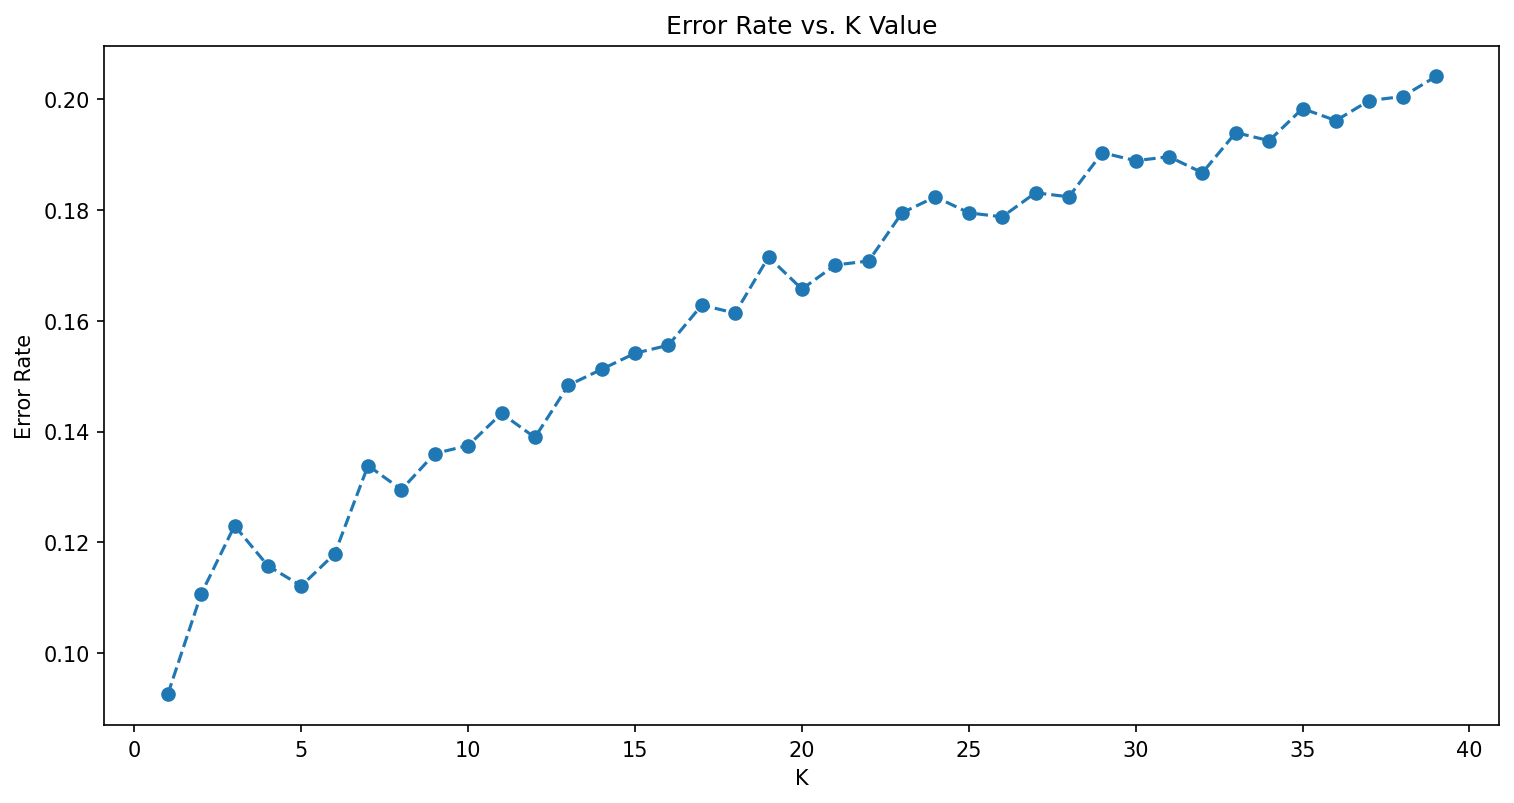

In [ ]:
err = []
for i in range(1, 40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    err.append(np.mean(yhat != y_test))
    
plt.figure(figsize=(12, 6), dpi=150)
plt.plot(range(1,40), err, linestyle='dashed', marker='o')
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
estimator_knn = KNeighborsClassifier()

parameters_knn = {
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'n_neighbors': [5],
    'leaf_size': [20, 40, 1],
    'p': [1, 2],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'chebyshev', 'euclidean', 'manhattan'],
}
                   

gs_knn = GridSearchCV(
    estimator=estimator_knn,
    param_grid=parameters_knn,
    verbose = 1,
    n_jobs = -1,
    cv = 3,
)

knn_tuned = gs_knn.fit(X_train, y_train)

eval_classification(knn_tuned, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Accuracy: 0.89
precision: 0.78
Recall: 0.93
AUC: 0.96


In [ ]:
knn_tuned.best_params_

{'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 5,
 'p': 1,
 'weights': 'distance'}

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       941
           1       0.78      0.93      0.85       441

    accuracy                           0.89      1382
   macro avg       0.87      0.90      0.88      1382
weighted avg       0.90      0.89      0.90      1382



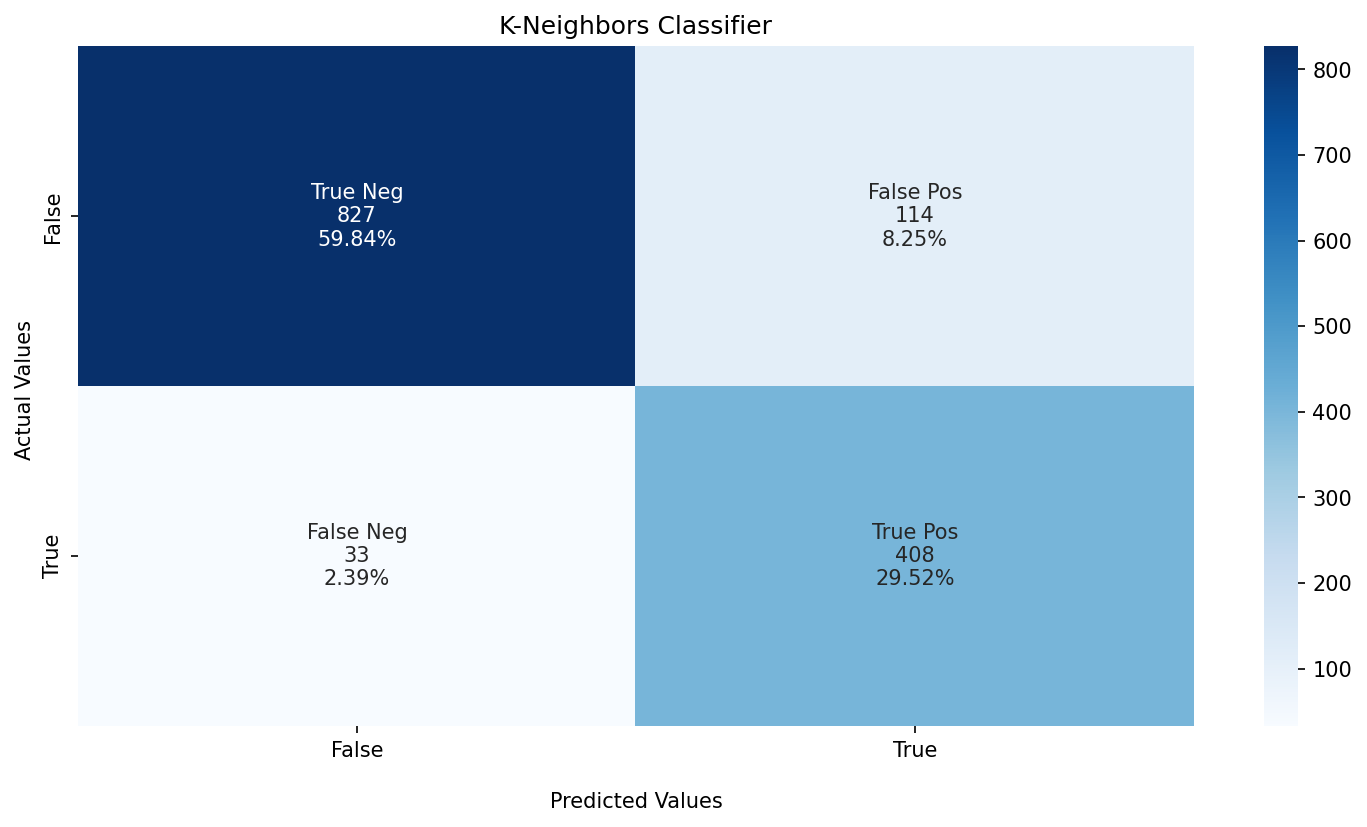

In [ ]:
cf_matrix_model("K-Neighbors Classifier", knn_tuned)

**Observations**:

- After tuning, the model *Recall* score in the KNN model increased by 1%. Previously it had a score of 92%, after that it became 93%.

# **Conclusions**

1. Based on the correlation table of features for stroke, the features with the highest correlation are Age, Heart Disease, Average Glucose Level, and Hypertension.
2. The older a person is, the more likely they are to have a stroke.
3. From the EDA, the number of people who do not have heart disease is higher, but the percentage of having a stroke is higher for someone who has heart disease.
4. From the EDA, the older you are, the higher the Everage Glucose Level and someone with a higher Everage Glucose Level tends to be more likely to have a stroke.
5. From the EDA, it's the same as Heart Disease that in the data someone who has hypertension is less than those who don't, but the potential for someone with hypertension has a higher risk of stroke.
6. The selection of the model is based on the Recall score, this is because it considers not allowing large False Negative values ​​or actually being said to be a stroke but predicting no stroke.
7. In the KNN model, after hyperparameter tuning, a recall score of 93% was obtained.